# Momentum in the S&P500 Universe

# Introduction

Although the public equity markets are highly accessible for nearly all classes of global investors, these markets pose some significant challenges. In particular, there is a significant degree of co-movement across single stocks, making the construction of a well-diversified portfolio difficult. The high degree of co-movement makes an investor vulnerable to broad-based declines in equity markets. 

One of the simplest and most effective strategies employed by active investors to control the risk associated with broad-based declines and enhance performance when markets are rising, involves exploiting a well-known stylized fact of equity markets, namely that stocks that are moving strongly in a particular direction have a tendency to continue to move in the same direction (i.e., they possess ‘momentum’). Momentum investing systems focus on identifying stocks that are moving persistently in a particular direction and taking a position to benefit from the directional movement. The long-only version of such strategies buys stocks that are rising most persistently and exits long positions when markets reverse.

To reduce the volatility of such a strategy, stocks that move together are typically grouped and bet as though they represent a single ‘factor’. Indeed, the most challenging aspect of a momentum system is not the identification of momentum stocks, but rather the selection of diverse groups of stocks that – when held together – provide portfolio return smoothing. In this paper we explore the sensitivity of suck a strategy to directional movement and explore the dependence between stocks held in the strategy portfolio using principal component analysis.

This paper is composed of four main sections encompassing the entire data science workflow.

### Section 1: Data
In the first section of the paper, we review the Python functions used to acquire data employed in the other sections.

### Section 2: Momentum Strategy Overview
In the second section of the paper, we implement an equity momentum strategy in Python and highlight some of its basic characteristics.

### Section 3: Modeling
In the third section of the paper, we provide an overview of the theory underlying the statistical factor model we use to explore the relatinship beteen stocks in our chosen universe, then conduct some limited sensitivity analysis and historical back-testing.

### Section 4: Conclusions
In the final section of the paper we provide our conclusions about the project.

## Set-Up

The following packages are used and must be installed:

In [2]:
# inline matplotlib
%matplotlib inline

# import the packages required for the project
import MySQLdb
import matplotlib.pyplot as plt
import seaborn
from timeit import default_timer as timer
import datetime
import dateutil
import requests
import pandas
import os
import shutil
import math
import numpy
import pandas.io.sql as sql
from pandas.tseries.offsets import CustomBusinessDay,MonthBegin
import pandas_datareader.data as web

This project also requires that MySQL be installed. 

Before running the project with the 'dataAcquisitionFlag' set to 'True', one must create a MySQL database called 'global_monitoring' and provide the database parameters listed immediately below.

In [3]:
# database parameters (mysql)
dbHost='localhost'
dbPort=3306
dbUser='root'
dbPassword='TGDNrx78'
databaseName='global_monitoring'

Setting the 'dataAcquisitionFlag' to 'True' will create the required directories under the base directory provided immediately below and run the portions of code used to fetch the iShares holdings files and yahoo price data for the date range (also set below).

In [4]:
# select a base directory where the project will create folders to store data
baseDirectory='C:/Users/DerekG/Documents/github/IS602/'

# set flags
dataAcquisitionFlag=True

# set the start date
startDate = datetime.datetime(2006,10,31,0,0,0)
# set the end date
endDate = datetime.datetime(2015,11,30,0,0,0)

If the project has been pulled from github, then the 'dataAcquisitionFlag' can be set to 'False' and data will be loaded from the HDF5 files associated with the project.

# Data

In this section of the paper we acquire, transform and load the iShares ETF holdings data. This data is then used to acquire the price data for all of the constituents of the iShares S&P500 ETF available from yahoo finance over the period between 2006-10-31 and 2015-11-30 (set above).

## Raw Data Acquisition/Extraction, Transformation, and Loading (ETL)

In this section we acquire the data required to backtest our simple trading strategy, namely the iShares ETF constituent holdings data and the associated price data.

The following utility functions are used to connect to the MySQL database, show tables, determine whether a table exists or disconnect from the database:

In [5]:
def dbConnect(dbHost,dbPort,dbUser,dbPassword,databaseName):

    try:
        dbHandle=MySQLdb.connect(host=dbHost, port=int(dbPort), 
        user=dbUser, passwd=dbPassword, db=databaseName)
        print("Connected to " + databaseName + " on " + dbHost + ":" + str(dbPort))
        return dbHandle
    
    except MySQLdb.Error,e:
        print("Cannot connect to "  + databaseName + " on " + dbHost + ":" + str(dbPort))
        print ("Error code:",e.args[0])
        print ("Error message:",e.args[1])

    return

def dbDisconnect(dbHandle):

    try:
        dbHandle.close()
        print("disconnected...")
        
    except:
        print ("database handle is not valid")

def showTablesLike(dbHandle,tableName):

    query="SHOW TABLES LIKE '" + str(tableName) + "';"
    cursor = dbHandle.cursor()
    cursor.execute(query)

    tableNameList=list()
    for table in cursor.fetchall():
        tableNameList.append(str(table[0]))
            
    return tableNameList

def doesTableExist(dbHandle,tableName):

    tableNameList=showTablesLike(dbHandle,tableName)
    if len(tableNameList) > 0:
        flag=True
    else:
        flag=False
            
    return flag

### iShares ETF Holdings Data Acquisition

The following functions are used to iterate over the available months of iShares holdings data and download the files:

In [6]:
def ensure_directory(f):
    d = os.path.dirname(f)
    if not os.path.exists(d):
        os.makedirs(d)

def fetchISharesUsHoldings(outputDirectory,productId,productName,fundTicker,asOfDate):    
    # set the URL
    url="https://www.ishares.com/us/products/"+productId+"/"+productName+"/1449138789749.ajax?fileType=csv&fileName="+fundTicker+"_holdings&dataType=fund&asOfDate="+asOfDate.strftime('%Y/%m/%d')
    # fetch the page
    r = requests.get(url)
    # create theoutput file name
    outputFileName=fundTicker+"_holdings_"+asOfDate.strftime('%Y%m%d')    
    # create the file handle
    outputFileHandle = open(outputDirectory+outputFileName,'w')
    # write the write
    outputFileHandle.write(r.content)
    # close the output file
    outputFileHandle.close()
    # return the output file name
    return outputFileName
 
def fetchISharesUsHoldingsForDateRange(startDateTime, endDateTime,iSharesUS,errorFileHandle):
    # create the date range
    asOfDates = pandas.bdate_range(startDateTime, endDateTime,freq='M')
    # iterate over each fund
    for fundName in iSharesUS:
        # fetch the fund product id and name
        fundIdentifiers=iSharesUS[fundName]
        fundIdentifiers=fundIdentifiers.split('|')
        fundTicker=fundIdentifiers[0]
        # extract the product id
        productId=fundIdentifiers[1]
        # extract the product name
        productName=fundIdentifiers[2]    
        # iterate over each as of date
        for asOfDate in asOfDates:
            # create the output file name
            outputFileName=fundTicker+"_holdings_"+asOfDate.strftime('%Y%m%d')
            
            try:
                # fetch iShares holdings
                fetchISharesUsHoldings(outputDirectory,productId,productName,fundTicker,asOfDate)
                # check the file size
                fileSize=os.path.getsize(outputDirectory+outputFileName)
                # check file size
                if (fileSize<=4):
                    try:
                        # remove empty file        
                        os.remove(outputDirectory+outputFileName)                
                    except:
                        print('cannot remove '+outputDirectory+outputFileName)         
            except:
                # write the write
                errorFileHandle.write(fundName+"|"+fundTicker+"|"+productId+"|"+outputDirectory+"|"+outputFileName+"|"+asOfDate.strftime('%Y%m%d')+"\n")

                pass
    return errorFileHandle

We download the raw holdings files with the following code:

In [7]:
if (dataAcquisitionFlag==True):
    # US fund list
    iSharesUS={}
    iSharesUS['iShares Core S&P 500 ETF']='IVV|239726|ishares-core-sp-500-etf'
    # set the error file directory
    errorDirectory=baseDirectory+'data/iShares/'
    # set the output holdings file directory
    outputDirectory=baseDirectory+'data/iShares/raw/'
    # create the directory if it does not exist
    ensure_directory(errorDirectory)
    # create the directory if it does not exist
    ensure_directory(outputDirectory)
    # create error output file
    errorFileName="error_"+endDate.strftime('%Y%m%d')+"_"+startDate.strftime('%Y%m%d') 
    # create the error file handle
    errorFileHandle = open(errorDirectory+errorFileName,'w')
    # start timer
    ts_raw = timer()
    # fetch the iShares US holdings for the date range
    errorFileHandle=fetchISharesUsHoldingsForDateRange(startDate, endDate,iSharesUS,errorFileHandle)
    # end time
    te_raw = timer()
    timeElasped_raw=te_raw-ts_raw
    print('Time Elasped: '+str(timeElasped_raw))
    # close the output file
    errorFileHandle.close()

Time Elasped: 132.957096259


### iShares ETF Holdings Data Preprocessing
The next set of functions is used to read the raw holding files and preprocess them for loading to the MySQL database:

In [8]:
def findFiles(files,searchString):
    return [i for i in files if searchString in i]

def cleanInstrumentTickers(value):
    value=value.replace('*','')
    
    return value

def cleanValue(value):
    value=value.replace(',','')
    value=value.replace('$','')
    
    return value

def firstLetterLower(s):
   if len(s) == 0:
      return s
   else:
      return s[0].lower() + s[1:]

def cleanColumnNames(columnNames):
    
    columnNamesList=list()
    for columnName in columnNames:
        columnName=columnName.title()
        columnName=firstLetterLower(columnName)
        columnName=columnName.replace(' ','')
        columnName=columnName.replace('(%)','Percent')
        columnNamesList.append(columnName)
    
    return columnNamesList

def readFundAttributesUS_EQ(outputDirectory,outputFileName):
    # create the full path file name
    fileName=outputDirectory+outputFileName
    #
    fundAttributes=pandas.read_csv(fileName,skiprows=1,nrows=7,na_values=['-'],header=None,
        index_col=[0],names=['value'])
   
    return fundAttributes

def readFundComponentsUS_EQ(outputDirectory,outputFileName,fundTicker):
    # set the converters
    convertersDictionary={}
    convertersDictionary['Ticker']=cleanInstrumentTickers
    convertersDictionary['Market Value']=cleanValue
    convertersDictionary['Shares']=cleanValue
    convertersDictionary['Notional Value']=cleanValue
    convertersDictionary['Price']=cleanValue 
    # create the full path file name
    fileName=outputDirectory+outputFileName
    # read the data
    data=pandas.read_csv(fileName,skiprows=10,skipfooter=1,engine='python',na_values=['-'],
        converters=convertersDictionary)
     # find the missing ticker
    index1=(data['Ticker']).isnull()
    # create an index for missing name
    index2=(data['Name']).isnull()
    # create an index for the records without tickers, names, coupons, or maturity
    nullIndex = index1 | index2
    # extract the records without tickers or names
    errorData=data.loc[nullIndex,]        
    # remove the holdings without tickers or names 
    data=data.loc[~nullIndex,]                                  
    # extract the column names
    columnNames=list(data)
    # pre-process column names
    columnNames=cleanColumnNames(columnNames)
    # re-name columns
    data.columns=columnNames
    # read the fund name
    fileHandle = open(fileName, 'r')
    fundName = fileHandle.readline()
    # read the fund attributes
    fundAttributes=readFundAttributesUS_EQ(outputDirectory,outputFileName)
    # extract the inception date
    inceptionDate=fundAttributes['value'][0]
    # extract the fund holdings as of date
    fundHoldingsAsOfDate=fundAttributes['value'][1]
    # extract total net assets
    totalNetAssets=fundAttributes['value'][2]
    # extract the shares outstanding
    sharesOutstanding=fundAttributes['value'][3]
    # fund attributes
    data['fundName']=fundName.replace('\n','')
    data['fundTicker']=fundTicker
    data['inceptionDate']=dateutil.parser.parse(inceptionDate)
    data['fundHoldingsAsOfDate']=dateutil.parser.parse(fundHoldingsAsOfDate)
    errorData['fundName']=fundName.replace('\n','')
    errorData['fundTicker']=fundTicker
    errorData['inceptionDate']=dateutil.parser.parse(inceptionDate)
    errorData['fundHoldingsAsOfDate']=dateutil.parser.parse(fundHoldingsAsOfDate)
    
    try:
        data['totalNetAssets']=cleanValue(totalNetAssets)
        errorData['totalNetAssets']=cleanValue(totalNetAssets)
    except:
        data['totalNetAssets']=totalNetAssets
        errorData['totalNetAssets']=totalNetAssets
    try:
        data['sharesOutstanding']=cleanValue(sharesOutstanding)
        errorData['sharesOutstanding']=cleanValue(sharesOutstanding)
    except:
        data['sharesOutstanding']=sharesOutstanding
        errorData['sharesOutstanding']=sharesOutstanding
                                                    
    return data,errorData

### iShares ETF Holdings Data Loading

The following functions are used to create and load a MySQL table to store the iShares holdings:

In [9]:
def createISharesHoldingsTable_US_EQ(dbHandle,table):

    sql='CREATE TABLE '+table+' (dbUpdateTimestamp TIMESTAMP,instrument_ticker VARCHAR(40) NOT NULL,instrument_name VARCHAR(80),isin VARCHAR(24),sedol VARCHAR(15),weight_percent DECIMAL(20,10),sector VARCHAR(50),asset_class VARCHAR(60),market_value DECIMAL(30,2),shares BIGINT,price DECIMAL(20,10),exchange VARCHAR(100),notional_value DECIMAL(30,2),fund_name VARCHAR(100) NOT NULL,fund_ticker VARCHAR(40) NOT NULL,inception_date DATE,fund_holdings_as_of_date DATE NOT NULL,total_net_assets DECIMAL(30,10),shares_outstanding BIGINT, PRIMARY KEY ( instrument_ticker,fund_holdings_as_of_date,fund_name ) ) ENGINE=INNODB;'
    #print(sql+"\n")

    try:
        cursor = dbHandle.cursor()
        cursor.execute(sql)
                                
    except MySQLdb.Error,e:
        print ("Error code:",e.args[0])
        print ("Error message:",e.args[1])

    return

def loadISharesHoldingsTable_US_EQ(dbHandle,table,directoryName,fileName):
    
    sql="LOAD DATA LOCAL INFILE '" + directoryName + fileName + "' IGNORE INTO TABLE "+table+" FIELDS TERMINATED BY '|' LINES TERMINATED BY '\n' IGNORE 1 LINES (instrument_ticker,instrument_name,isin,sedol,weight_percent,sector,asset_class,market_value,shares,price,exchange,notional_value,fund_name,fund_ticker,inception_date,fund_holdings_as_of_date,total_net_assets,shares_outstanding);"
    #print(sql+"\n")

    try:
        cursor = dbHandle.cursor()
        cursor.execute(sql)
        dbHandle.commit()

    except MySQLdb.Error,e:
        print ("Error code:",e.args[0])
        print ("Error message:",e.args[1])
        print("Error: loadISharesHoldingsTable_US_EQ")
        print(table)
        print(outputDirectory+inputFileName)
        dbHandle.rollback()

    return

The function below is used to preprocess the raw historical holdings files:

In [10]:
# preprocess raw historical iShares holdings files
def preprocessHistoricalISharesHoldings(dbHandle,table,errorFileHandle,inputDirectory,outputDirectory,archiveDirectory):
    
    # set the find column names
    columnNames=['ticker','name','isin','sedol','weightPercent','sector','assetClass',
        'marketValue','shares','price','exchange','notionalValue','fundName','fundTicker',
        'inceptionDate','fundHoldingsAsOfDate','totalNetAssets','sharesOutstanding']    

    # get the list of raw files
    rawFiles=os.listdir(inputDirectory)
    # iterate over each of the EQ ETFs
    for fundName in holdingsUS_EQ:
        print(fundName)
        # extract the fund ticker
        fundTicker=holdingsUS_EQ[fundName]
        # find the raw files associated with the fund ticker
        rawFiles_US_EQ=findFiles(rawFiles,fundTicker)      
        # iterate over the files associated with the fund ticker
        for inputFileName in rawFiles_US_EQ:
            print(inputFileName)
            # read the US EQ data
            data,errorData=readFundComponentsUS_EQ(inputDirectory,inputFileName,fundTicker)
            # export the preprocessed data
            data.to_csv(outputDirectory+inputFileName,sep='|',index=False,na_rep='\N',
                line_terminator='\n',columns=columnNames)
            # write the error holdings
            errorData.to_csv(errorFileHandle,mode='a',sep='|',index=False,na_rep='\N',
                encoding='utf-8',header=False,float_format='%.10f',line_terminator='\n',
                columns=columnNames)
            # load the holdings table
            loadISharesHoldingsTable_US_EQ(dbHandle,table,outputDirectory,inputFileName)
            # move the raw file to archive
            shutil.move(inputDirectory+inputFileName,archiveDirectory+inputFileName)
            
    return errorFileHandle

We connect to the database:

In [11]:
# connect to the 'global_monitoring' MySQL database 
dbHandle=dbConnect(dbHost,dbPort,dbUser,dbPassword,databaseName)

Connected to global_monitoring on localhost:3306


Next, we iterate over each of the raw holdings files downloaded from the iShares website, preprocess, then load the files to the database:

In [12]:
if (dataAcquisitionFlag==True):
    # create dictionary of ETFs to collect
    holdingsUS_EQ={}
    holdingsUS_EQ['iShares Core S&P 500 ETF']='IVV'
    # set the input and output directories
    errorDirectoryName=baseDirectory+'data/iShares/'
    inputDirectory=baseDirectory+'data/iShares/raw/'
    outputDirectory=baseDirectory+'data/iShares/preprocess/'
    archiveDirectory=baseDirectory+'data/iShares/archive/'
    # create the directory if it does not exist
    ensure_directory(outputDirectory)
    # create the directory if it does not exist
    ensure_directory(archiveDirectory)
    
    # determine the current datetime
    runDateTime=datetime.datetime.now()

    # create the error tracking file
    errorFileName='error_'+runDateTime.strftime('%Y%m%d')

    # open error tracking output file handle
    errorFileHandle = open(errorDirectoryName+errorFileName,'w')

    # set output header column names
    columnNames=['ticker','name','isin','sedol','weightPercent','sector','assetClass',
        'marketValue','shares','price','exchange','notionalValue','fundName','fundTicker',
        'inceptionDate','fundHoldingsAsOfDate','totalNetAssets','sharesOutstanding']

    # write the header
    errorFileHandle.write('|'.join(columnNames)+'\n')
    table='ishares_us_eq_holdings'

    # create the holdings table
    if not doesTableExist(dbHandle,table):
        # create the holdings table
        createISharesHoldingsTable_US_EQ(dbHandle,table)

    # start timer
    ts_preprocess = timer()
    # preprocess raw historical iShares holdings files
    errorFileHandle=preprocessHistoricalISharesHoldings(dbHandle,table,errorFileHandle,
        inputDirectory,outputDirectory,archiveDirectory)

    # end time
    te_preprocess = timer()
    timeElasped_preprocess=te_preprocess-ts_preprocess
    print('Time Elasped: '+str(timeElasped_preprocess))    

    # close error tracking output file handle
    errorFileHandle.close()
    
    query="SELECT instrument_ticker,instrument_name FROM ishares_us_eq_holdings WHERE fund_ticker='IVV' AND asset_class='Equity' GROUP BY instrument_ticker"

    instruments=sql.read_sql(query,con=dbHandle,coerce_float=True)
    
    # set the HDF5 output file directory
    output_directory=baseDirectory+'data/iShares/HDF5/'
    # create the directory if it does not exist
    ensure_directory(output_directory)    
    output_file='sp500_iShares_IVV_holdings.h5'
    # create the HDF5 data store
    data_store = pandas.HDFStore(output_directory+output_file)
    # store the 'instruments' data frame in the HDF5 data store
    data_store['instruments'] = instruments
    # close the HDF5 data store
    data_store.close()
    
elif (dataAcquisitionFlag==False):
    try:
        # read the instruments data from the HDF5 data store
        instruments = pandas.read_hdf(output_directory+output_file,'instruments')
    except:
        print('The data acquisition must be run at least once.')
        print('Please re-run with the dataAcquisitionFlag set to True')  

iShares Core S&P 500 ETF
IVV_holdings_20061031
IVV_holdings_20061130
IVV_holdings_20070131
IVV_holdings_20070228
IVV_holdings_20070430
IVV_holdings_20070531
IVV_holdings_20070731
IVV_holdings_20070831
IVV_holdings_20071031
IVV_holdings_20071130
IVV_holdings_20071231
IVV_holdings_20080131
IVV_holdings_20080229
IVV_holdings_20080331
IVV_holdings_20080430
IVV_holdings_20080630
IVV_holdings_20080731
IVV_holdings_20080930
IVV_holdings_20081031
IVV_holdings_20081231
IVV_holdings_20090331
IVV_holdings_20090430
IVV_holdings_20090630
IVV_holdings_20090731
IVV_holdings_20090831
IVV_holdings_20090930
IVV_holdings_20091130
IVV_holdings_20091231
IVV_holdings_20100331
IVV_holdings_20100430
IVV_holdings_20100630
IVV_holdings_20100831
IVV_holdings_20100930
IVV_holdings_20101130
IVV_holdings_20101231
IVV_holdings_20110131
IVV_holdings_20110228
IVV_holdings_20110331
IVV_holdings_20110531
IVV_holdings_20110630
IVV_holdings_20110831
IVV_holdings_20110930
IVV_holdings_20111031
IVV_holdings_20111130
IVV_hol

### Price Data for ETF Constituents

In this section, we use the ETF holdings data to build the instrument universe we will use to test our momentum strategy. We iterate over each constituent stock held by the iShares S&P500 ETF over the period between 2006-10-31 and 2015-11-30 and attempt to get corresponding price, dividend, and stock split data.

The function immediately below is used to pull price data from yahoo finance.

In [13]:
# fetch yahoo data for ticker between start and end dates
def fetchYahooData(yahooTicker,instrumentName,startDate, endDate):
    # fetch historical data
    df = web.DataReader(yahooTicker, 'yahoo', startDate, endDate)
    corporateActions=web.DataReader(yahooTicker, 'yahoo-actions', startDate, endDate)

    # iterate backwards over the prices and compute the adj factor

    df1=df.copy(deep=True)

    #dateTime=df1.index
    openPrice=numpy.array(df1['Open'].values, dtype='d')
    highPrice=numpy.array(df1['High'].values, dtype='d')
    lowPrice=numpy.array(df1['Low'].values, dtype='d')
    closePrice=numpy.array(df1['Close'].values, dtype='d')
    adjustedClosePrice=numpy.array(df1['Adj Close'].values, dtype='d')
        
    T=len(df)
    adjustCount=0
    for t in xrange(T-1,-1,-1):
       
        if closePrice[t] != adjustedClosePrice[t]:
            factor = adjustedClosePrice[t]/closePrice[t]
            adjustCount=adjustCount+1
            
            for tt in xrange(t,-1,-1):
                openPrice[tt]=openPrice[tt]*factor
                highPrice[tt]=highPrice[tt]*factor
                lowPrice[tt]=lowPrice[tt]*factor
                closePrice[tt]=closePrice[tt]*factor                

    df['adjOpen']=numpy.array(openPrice, dtype='d')
    df['adjHigh']=numpy.array(highPrice, dtype='d')
    df['adjLow']=numpy.array(lowPrice, dtype='d')
    df['adjClose']=numpy.array(closePrice, dtype='d')
                            
    # add true range and 20d ATR
    previousClosePrice=df['adjClose'].shift(1)
    a=df['adjHigh']-df['adjLow']
    b=abs(df['adjHigh']-previousClosePrice)
    c=abs(previousClosePrice-df['adjLow'])
    test=pandas.concat([a,b,c],axis=1)
    # compute true range
    trueRange=test.max(axis=1,skipna=False)
    trueRange.reindex(df.index,method='ffill')
    df['trueRange']=trueRange
    # compute the 20d atr
    atrLookback=20
    atr=pandas.ewma(trueRange,span=atrLookback,min_periods=atrLookback)
    df['atr_20d']=numpy.array(numpy.around(atr, decimals=2, out=None), dtype='d')
    # concat the data frames
    data=pandas.concat([df,corporateActions],axis=1,join='outer')
        
    ## add instrument info              
    data['yahooTicker']=str(yahooTicker)
    data['instrumentName']=str(instrumentName)

    return data

Using the above function, we can pull the price, dividend, and stock split data for the S&P500 iShares ETF as follows:

In [14]:
instrumentTicker='IVV'
instrumentName='iShares Core S&P 500 ETF'
# fetch the data from yahoo
data=fetchYahooData(instrumentTicker,instrumentName,startDate,endDate)
print(data.tail())

                  Open        High         Low       Close   Volume  \
2015-11-23  210.479996  211.169998  209.710007  210.220001  2329200   
2015-11-24  208.960007  211.009995  208.610001  210.520004  3222000   
2015-11-25  210.729996  210.929993  210.250000  210.529999  1887000   
2015-11-27  210.600006  210.990005  210.059998  210.710007  1062400   
2015-11-30  211.000000  211.080002  209.750000  209.869995  5283300   

             Adj Close     adjOpen     adjHigh      adjLow    adjClose  \
2015-11-23  210.220001  210.479996  211.169998  209.710007  210.220001   
2015-11-24  210.520004  208.960007  211.009995  208.610001  210.520004   
2015-11-25  210.529999  210.729996  210.929993  210.250000  210.529999   
2015-11-27  210.710007  210.600006  210.990005  210.059998  210.710007   
2015-11-30  209.869995  211.000000  211.080002  209.750000  209.869995   

            trueRange  atr_20d action  value yahooTicker  \
2015-11-23   1.459991     2.12    NaN    NaN         IVV   
2015-11-

We can now fetch the list of constituent tickers associated with the S&P500 iShares ETF from the MySQL database, then attempt to fetch the price and corporate action data for each constituent:

In [15]:
if (dataAcquisitionFlag==True):
    dataDictionary=dict()
    error=dict()

    # start timer
    ts_fetchPrices = timer()

    # iterate over each row in the dataframe
    for instrument in instruments.iterrows():
        #print(instrument)
        instrumentTicker=instrument[1]['instrument_ticker']
        instrumentName=instrument[1]['instrument_name']
        try:
            data=fetchYahooData(instrumentTicker,instrumentName,startDate,endDate)
            dataDictionary[instrumentTicker]=data
        except:
            error[instrumentTicker]=instrumentName

    # convert the error dictionary to a dataframe
    errorData=pandas.DataFrame.from_dict(error,orient='index')            
    # end timer
    te_fetchPrices = timer()
    timeElasped_fetchPrices=te_fetchPrices-ts_fetchPrices
    print('Time Elasped: '+str(timeElasped_fetchPrices))
   
    # create the data panel
    groupData=pandas.Panel.from_dict(dataDictionary,orient='minor')
    # extract the prices
    prices=groupData['adjClose']
    # extract the true ranges
    trueRanges=groupData['trueRange']    

    # set the HDF5 output file directory
    output_directory=baseDirectory+'data/yahoo/HDF5/'
    # create the directory if it does not exist
    ensure_directory(output_directory)      
    output_file='sp500_iShares_IVV.h5'
    # create the HDF5 data store
    data_store = pandas.HDFStore(output_directory+output_file)
    # store the 'prices' data frame in the HDF5 data store
    data_store['price'] = prices
    # store the 'true ranges' data frame in the HDF5 data store
    data_store['trueRange'] = trueRanges
    # store the 'error tickers' data frame in the HDF5 data store
    data_store['error'] = errorData
    # close the HDF5 data store
    data_store.close() 
    
elif (dataAcquisitionFlag==False):
    try:
        # read the price data from the HDF5 data store
        prices = pandas.read_hdf(output_directory+output_file,'price')
        # read the true range data from the HDF5 data store
        trueRanges = pandas.read_hdf(output_directory+output_file,'trueRange')
        #
        errorData = pandas.read_hdf(output_directory+output_file,'error')
    except:
        print('The data acquisition must be run at least once.')
        print('Please re-run with the dataAcquisitionFlag set to True')

Time Elasped: 1878.37512669


Given the amount of time that it takes to fetch this data, we store the data in a HDF5 file for later use.

Close the database connection:

In [16]:
# disconnect from MySQL
dbDisconnect(dbHandle)

disconnected...


In [17]:
len(instruments)

772

In [18]:
instruments.tail()

,instrument_ticker,instrument_name
767,YUM,YUM BRANDS INC
768,ZBH,ZIMMER BIOMET HOLDINGS INC
769,ZION,ZIONS BANCORPORATION
770,ZMH,ZIMMER HOLDINGS INC
771,ZTS,ZOETIS INC CLASS A


## Data Cleaning

Although by definition there are roughly 500 stocks held by the iShares S&P500 ETF at any given instant in time, there were 772 distinct tickers associated with holdings of the iShares S&P500 ETF over the period between 2006-10-31 and 2015-11-30. The difference between 772 and 500 reflects the changing composition of the index over time. In particular, stocks are added or dropped according to the rules of the index or as a result of corporate actions (such as name changes or mergers and acquisitions).

Corporate actions make it difficult to determine how many truly distinct stocks were in the S&P500 universe over the period without more detailed corporate actions information. Unfortunately, such information is typically very expensive to obtain. Using publically available data thus significantly limits our ability to construct a research-ready database for strategy testing. For this reason, the sections below pertaining to the back-testing of our strategy will likely produce performance that is biased and should be considered to provide only the basic behavioral characteristics of the strategy. Full walk-forward testing and risk and performance attribution is unlikely to provide much value given our data limitations and thus has been abandoned in favor of sensitivity analysis and an exploration of the dependence between stocks in our instrument universe.

We load the data from the HDF5 files:

In [19]:
# load the data
fileDirectory=baseDirectory+'data/yahoo/HDF5/'
fileName='sp500_iShares_IVV.h5'
prices=pandas.read_hdf(fileDirectory+fileName,'price')
trueRanges=pandas.read_hdf(fileDirectory+fileName,'trueRange')
errorData=pandas.read_hdf(fileDirectory+fileName,'error')

In [20]:
print(groupData)

<class 'pandas.core.panel.Panel'>
Dimensions: 16 (items) x 2370 (major_axis) x 650 (minor_axis)
Items axis: Open to value
Major_axis axis: 2006-10-31 00:00:00 to 2015-11-30 00:00:00
Minor_axis axis: 0R01 to ZTS


In [21]:
print(prices.tail())

            0R01  6COP  8686          A     A60    AA        AAL         AAP  \
2015-11-24   NaN   NaN  8030  40.669998  283.98  9.09  41.230000  163.124570   
2015-11-25   NaN   NaN  8020  41.340000  290.52  9.41  41.310001  164.234125   
2015-11-26   NaN   NaN  8020        NaN  300.05   NaN        NaN         NaN   
2015-11-27   NaN   NaN  7960  41.970001  300.93  9.32  41.689999  164.773902   
2015-11-30   NaN   NaN  7980  41.820000  300.60  9.36  41.259998  162.664747   

                  AAPL    AAZ    ...           XLNX        XOM       XRAY  \
2015-11-24  118.879997  58.53    ...      49.230000  81.879997  61.045699   
2015-11-25  118.029999  58.30    ...      49.009998  81.250000  60.875908   
2015-11-26         NaN  57.65    ...            NaN        NaN        NaN   
2015-11-27  117.809998  57.33    ...      49.230000  81.230003  61.035713   
2015-11-30  118.300003  57.57    ...      49.689999  81.660004  60.586259   

              XRX        XYL       YHOO        YUM      

True range:

In [22]:
print(trueRanges.tail())

            0R01  6COP  8686         A   A60    AA       AAL       AAP  \
2015-11-24   NaN   NaN    70  0.990001  9.37  0.23  1.849998  3.038775   
2015-11-25   NaN   NaN    10  1.029999  6.54  0.42  0.540001  3.878448   
2015-11-26   NaN   NaN     0       NaN  9.53   NaN       NaN       NaN   
2015-11-27   NaN   NaN    60  1.040001  0.88  0.16  1.080002  2.049181   
2015-11-30   NaN   NaN    20  0.439998  0.33  0.20  1.010002  2.229102   

                AAPL   AAZ    ...         XLNX       XOM      XRAY   XRX  \
2015-11-24  2.229995  1.89    ...     1.149998  2.150001  1.338371  0.60   
2015-11-25  1.310005  0.58    ...     0.559998  1.070000  0.699150  0.29   
2015-11-26       NaN  0.73    ...          NaN       NaN       NaN   NaN   
2015-11-27  0.810006  0.81    ...     0.360000  0.800003  0.559320  0.10   
2015-11-30  1.660004  1.32    ...     0.770000  1.419999  0.799031  0.18   

                 XYL      YHOO       YUM       ZBH      ZION       ZTS  
2015-11-24  0.510003  0.7

In [ ]:
tickers=prices.columns.values

Of the 772 distinct tickers represented in our holdings database, 650 have data available on yahoo finance, while the remaining 122 tickers have no data.

Upon closer inspection we can see that there are a number of tickers that have very limited data.

The extensive manual data cleaning required to prepare this public data set for robust strategy research is far beyond the scope of this project so we perform some basic data cleaning, then proceed with our modelling efforts. 

Although the strategy results obtained using this data can provide a useful indication of the behavior of the strategy, the specific performance results are unlikely to be robust given the quality of our data.

We first examine the data for which prices were not available.

In [24]:
print(errorData.sort_index(axis=0))

                                          0
3EC                               EATON PLC
4XS              EXPRESS SCRIPTS HOLDING CO
ACT                            ACTAVIS INC.
ADCT                 ADC TELECOMMUNICATIONS
ADP           AUTOMATIC DATA PROCESSING INC
AHEB GR                  ALBERTO-CULVER CO.
APCC.    AMERICAN POWER CONVERSION CORPORAT
ASD               AMERICAN STANDARD COS INC
ASO.1                AMSOUTH BANCORPORATION
AT.                            ALLTEL CORP.
AV.1                             AVAYA INC.
AW             ALLIED WASTE INDUSTRIES INC.
AYE                        ALLEGHENY ENERGY
BF.B              BROWN FORMAN CORP CLASS B
BJS                          BJ SERVICES CO
BLD WI            TOPBUILD CORP WHEN ISSUED
BLS                   BELLSOUTH CORPORATION
BMC                       BMC SOFTWARE INC.
BMET                            BIOMET INC.
BNI                     BURLINGTON NORTHERN
BRKB         BERKSHIRE HATHAWAY INC CLASS B
BSC.1                BEAR STEARN

The above list of single stocks for which price data was not available on yahoo includes Bear Stearns (which was absorbed by JP Morgan Chase during the financial crisis), Visa Inc. (which is no longer associated with the ticker VISA, but instead is included in our data set under the ticker V), and Allied Waste Industries Inc. (which was acquired by Republic Services Inc in 2008). Wendy's International Inc. (in the list above under WEN.2) is available from yahoo and is included in our data set.

Manually searching by company name allows us to determine how to address many of the issues that arise, the time required to review each ticker and ensure that it has been handled correctly is considerable and out of scope for this project. We proceed with some limited cleaning.

The first step in our data cleaning process involves applying a 'forward fill' interpolation to fill missing days with the most recent previous day.

In [25]:
# apply forward fill to prices
prices=prices.fillna(method='ffill')
# apply forward fill to true range
trueRanges=trueRanges.fillna(method='ffill')

We can see the number of observations available for each ticker using the following operation:

In [26]:
# find the number of observations available for each ticker
numberOfObservations=numpy.sum(prices.isnull()==False,axis=0)
# print the result
print(numberOfObservations)

0R01      278
6COP     2195
8686     2370
A        2370
A60      1556
AA       2370
AAL      2370
AAP      2370
AAPL     2370
AAZ      2076
ABBV      759
ABC      2370
ABI       824
ABKFQ    2370
ABT      2370
ACAS     2370
ACE      2370
ACN      2370
ACS      2370
ADBE     2370
ADI      2370
ADM      2370
ADS      2370
ADSK     2370
ADT       826
AEC1     2370
AEE      2370
AEP      2370
AES      2370
AET      2370
         ... 
WEC      2370
WEN      2370
WFC      2370
WFM      2370
WFR      2077
WFT      2370
WHR      2370
WM       2370
WMT      2370
WPI      2370
WPX      1036
WRK       114
WU       2370
WY       2370
WYN      2370
WYNN     2370
X        2370
XEC      2370
XEL      2370
XL       2370
XLNX     2370
XOM      2370
XRAY     2370
XRX      2370
XYL      1078
YHOO     2370
YUM      2370
ZBH      2370
ZION     2370
ZTS       737
dtype: int64


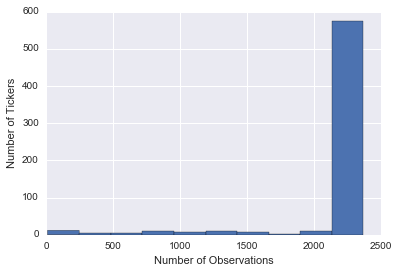

In [27]:
numberOfObservations.hist()
plt.xlabel('Number of Observations')
plt.ylabel('Number of Tickers')

We can see in the above graph that the majority of tickers have 2370 observations. To accelerate our data cleaning we drop all prices for which a full data sample is not available. While this will bias our results, it allows us to evaluate the basic characteristics of our momentum strategy, keeping the project in scope.

In [28]:
# find the single stocks with full samples
fullSampleIndex=numberOfObservations==2370
# extract the prices and true ranges for the single stocks with full samples
cleanPrices=prices.ix[:,fullSampleIndex]
cleanTrueRanges=trueRanges.ix[:,fullSampleIndex]

The following code is used to graph price and true range for each stock available. This code will not run by default, but can be run by changing the 'generateSingleStockPlots' variable to 'True'.

In [29]:
generateSingleStockPlots=False

if (generateSingleStockPlots==True):

    tickers=cleanPrices.columns
    for ticker in tickers:
        tickerName=ticker.replace('/','-')
        fig = plt.figure()
        cleanPrices[ticker].plot()
        plt.title(ticker) 
        fig.savefig(fileDirectory+tickerName+'_price.png',format='png')
        plt.close()
        fig = plt.figure()
        cleanTrueRanges[ticker].plot()
        plt.title(ticker) 
        fig.savefig(fileDirectory+tickerName+'_range.png',format='png')
        plt.close()

We review the available data and manually exclude tickers with issues.

In [30]:
excludeTickers=['8686','ABKFQ','ACS','AEC1','AG4','AIG','ANRZQ','ASN','BDK','BEAM','BF/B','BOL',
    'BRL','CEG','CFC','CMVT','CMX','CPWR','CVH','DELL','DYNIQ','EKDKQ','ETFC','FMCC','FNMA','FRX',
    'HMA','HNZ','HPC','ITT','JNY','LOM','LSI','LTD','LTR','MEDI','MER','MOLX','MTG','MWZ','NYX',
    'OMX','PCS','PETM','QLG','REGN','ROH','RTN1','SAF','SBL','SLR','SOV','SWG','THC1','TIE','TLAB',
    'TRB','TT','UNS1','USX1','UUM','WPI']
len(excludeTickers)

62

We exclude 62 tickers based on manual inspection of the data.

We remove each of the tickers identified above using the following code:

In [31]:
# remove problematic tickers
for ticker in excludeTickers:
    del cleanPrices[ticker]
    del cleanTrueRanges[ticker]

In [32]:
print(cleanPrices.tail())

                    A    AA        AAL         AAP        AAPL        ABC  \
2015-11-24  40.669998  9.09  41.230000  163.124570  118.879997  98.500000   
2015-11-25  41.340000  9.41  41.310001  164.234125  118.029999  98.930000   
2015-11-26  41.340000  9.41  41.310001  164.234125  118.029999  98.930000   
2015-11-27  41.970001  9.32  41.689999  164.773902  117.809998  98.989998   
2015-11-30  41.820000  9.36  41.259998  162.664747  118.300003  98.639999   

                  ABT   ACAS         ACE         ACN    ...            XEL  \
2015-11-24  45.450001  13.90  115.559998  107.349998    ...      35.407107   
2015-11-25  45.410000  15.22  115.050003  107.099998    ...      35.179186   
2015-11-26  45.410000  15.22  115.050003  107.099998    ...      35.179186   
2015-11-27  45.419998  15.54  115.059998  107.459999    ...      35.317920   
2015-11-30  44.919998  15.65  114.849998  107.220001    ...      35.337740   

                   XL       XLNX        XOM       XRAY    XRX       

In [33]:
print(cleanTrueRanges.tail())

                   A    AA       AAL       AAP      AAPL       ABC       ABT  \
2015-11-24  0.990001  0.23  1.849998  3.038775  2.229995  0.980003  0.550003   
2015-11-25  1.029999  0.42  0.540001  3.878448  1.310005  1.389999  0.370003   
2015-11-26  1.029999  0.42  0.540001  3.878448  1.310005  1.389999  0.370003   
2015-11-27  1.040001  0.16  1.080002  2.049181  0.810006  1.229996  0.289997   
2015-11-30  0.439998  0.20  1.010002  2.229102  1.660004  0.860001  0.620003   

            ACAS       ACE       ACN    ...          XEL        XL      XLNX  \
2015-11-24  0.46  1.250000  1.129997    ...     0.584668  0.586910  1.149998   
2015-11-25  1.34  0.860001  0.720001    ...     0.396383  0.636647  0.559998   
2015-11-26  1.34  0.860001  0.720001    ...     0.396383  0.636647  0.559998   
2015-11-27  0.45  0.790001  0.830002    ...     0.455846  0.278537  0.360000   
2015-11-30  0.40  1.110000  0.690003    ...     0.356744  0.417798  0.770000   

                 XOM      XRAY   XRX  

We check for relatively high prices:

In [34]:
# determine the max price by ticker
maxPriceByTicker=numpy.max(cleanPrices,axis=0)
print(cleanPrices.ix[:,maxPriceByTicker>1000])

                   BTU         PCLN
2006-10-31  541.869525    40.290001
2006-11-01  527.667559    40.529999
2006-11-02  534.381205    39.709999
2006-11-03  541.998654    39.700001
2006-11-06  544.839037    39.980000
2006-11-07  532.960987    40.139999
2006-11-08  535.155879    40.400002
2006-11-09  550.261595    39.830002
2006-11-10  535.414086    40.610001
2006-11-13  535.801423    41.349998
2006-11-14  536.576096    40.910000
2006-11-15  535.155879    40.180000
2006-11-16  528.442233    39.849998
2006-11-17  542.256861    39.759998
2006-11-20  538.383598    39.520000
2006-11-21  546.130125    39.889999
2006-11-22  548.970507    39.950001
2006-11-23  548.970507    39.950001
2006-11-24  550.648932    38.750000
2006-11-27  543.160612    38.930000
2006-11-28  554.134858    38.950001
2006-11-29  583.829877    40.049999
2006-11-30  594.029449    39.490002
2006-12-01  606.682172    39.130001
2006-12-04  607.456794    40.310001
2006-12-05  621.013215    39.220001
2006-12-06  612.621145    39

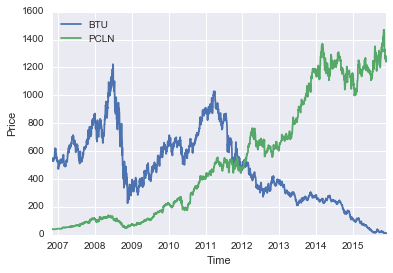

In [35]:
# find tickers with prices above 1000
cleanPrices.ix[:,maxPriceByTicker>1000].plot()
plt.ylabel('Price')
plt.xlabel('Time')

After some limited investigation it is determined that the prices of the above to stocks are 'clean'.

In the next section we outline our momentum strategy.

# Momentum Strategy Overview

In this section, we describe a simple momentum strategy and review an un-optimized Python implementation. First we create a set of un-optimized functions implementing our simple momentum strategy, then we examine the behavior of the strategy using simulated prices. This section is intended to help contextualize the sensitivity and back-test results presented in later sections.

The following code is used to simulate price paths based on geometric Brownian motion.

In [36]:
def assetPaths(S0,mu,sigma,T,nRows,nPaths):
    dt = T/nRows
    nudt = (mu-0.5*sigma**2)*dt    
    sidt = sigma*math.sqrt(dt)
    increments = nudt + sidt*numpy.random.randn(int(nRows),int(nPaths))
    x=numpy.concatenate((math.log(S0)*numpy.ones((1,int(nPaths))),increments))
    pricePaths=numpy.exp(numpy.cumsum(x,axis=0))

    return pricePaths

Using the above function, we simulate price paths for an instrument as follows:

In [37]:
# set the random seed
numpy.random.seed(1234)
# set simulation parameters
# inital price
S0=100.0
# mean annual return
mu=0.1 
# annual volatility (standard deviation)
sigma=0.1 
# time in years
T=3.0
# number of time steps
nRows=750.0
# number of paths / instruments
nPaths=1000.0
# start timer
ts_priceMC = timer()
# simulate instrument prices
pricePaths=assetPaths(S0,mu,sigma,T,nRows,nPaths)
# create true range
trueRangePaths=numpy.concatenate((numpy.zeros((1,int(nPaths))),
    abs(numpy.diff(pricePaths,axis=0))))
# end timer
te_priceMC = timer()
# compute time elasped
timeElasped_priceMC=te_priceMC-ts_priceMC
print('Time Elasped: '+str(timeElasped_priceMC))

Time Elasped: 0.0781705879149


The following functions are used to implement the indicators used within our strategy.

In [67]:
from scipy import stats
    
def emaNPaths(pricePaths,lookback):
    # find T and nPaths
    T,nPaths=pricePaths.shape
    # create output array
    ema=numpy.zeros([int(T),int(nPaths)])
    # compute the smoothing constant
    a = 2.0 / ( lookback + 1.0 )
    # iterate over each price path
    for pathIndex in range(0,int(nPaths)):
        # iterate over each price path
        ema[0,pathIndex] = pricePaths[0,pathIndex]
        # iterate over each point in time and compute the EMA 
        for t in range(1,T):
            ema[t,pathIndex]=a * (pricePaths[t,pathIndex]-ema[t-1,
                pathIndex]) + ema[t-1,pathIndex]
    return ema
    
# classical momentum
def momentum(pricePaths,lookback):
    # find T and nPaths
    T,nPaths=pricePaths.shape
    # create output array
    momentumPaths=numpy.zeros([int(T),int(nPaths)])
    # iterate over each price path
    for pathIndex in range(0,int(nPaths)):
        # iterate over each point in time and compute the EMA 
        for t in range(1,int(T)):
            if t>=lookback:
                momentumPaths[t,pathIndex]=((1+((numpy.log(pricePaths[t,
                    pathIndex])-numpy.log(pricePaths[t-lookback,
                    pathIndex]))/lookback))**252)-1

    return momentumPaths

# regression-based momentum
def regressionBasedMomentum(pricePaths,lookback):
    # find T and nPaths
    T,nPaths=pricePaths.shape
    # create the x-axis (time)
    x=numpy.arange(0,lookback)
    # create output array
    momentumPaths=numpy.zeros([int(T),int(nPaths)])
    # iterate over each price path
    for pathIndex in range(0,int(nPaths)):
        # iterate over each point in time and compute the EMA 
        for t in range(1,int(T)):
            if t>=lookback:
                # run regression
                slope, intercept, r_value, p_value, std_err = stats.linregress(x,
                    numpy.log(pricePaths[t-lookback:t,pathIndex]))
                # adjust the momentum for smoothness and annualize
                momentumPaths[t,pathIndex]=(((1+slope)**252)-1)*(r_value**2)
                                                  
    return momentumPaths
    
def gapFilter(pricePaths,lookback,threshold):
    # determine the number of rows and paths
    nRows,nPaths=pricePaths.shape
    # create output array
    gap=numpy.zeros([int(nRows),int(nPaths)])
    # iterate of each path
    for pathIndex in range(0,int(nPaths)):
        for t in range(0,int(nRows)):
            if t>=lookback:
                # find the max return gap over the interval between (t-lookback) and t
                gap[t,pathIndex]=numpy.max(numpy.abs(numpy.diff(numpy.log(pricePaths[t-lookback:t,
                    pathIndex]))))>=threshold
        
    return gap

The following function implements a classic momentum strategy for a set of stocks. This function is used in later sections pertaining to sensitivity analysis.

In [66]:
def momentumCrossoverWithStopClassic(strategyInputs):
    # extract strategy inputs/parameters
    
    # price by instrument    
    pricePaths=strategyInputs['pricePaths']
    # true range
    trueRangePaths=strategyInputs['trueRangePaths']
    # lookback for average true range indicator (ATR)
    atrLookback=strategyInputs['atrLookback']
    # number of ATRs used in stop placement and position sizing    
    atrMultiplier=strategyInputs['atrMultiplier']
    # lookback for the 'fast' EMA    
    fastLookback=strategyInputs['fastLookback']
    # lookback for the 'slow' EMA
    slowLookback=strategyInputs['slowLookback']
    # lookback for the momentum indicator
    momentumLookback=strategyInputs['momentumLookback']
    # True=long-only, False=long/short    
    longOnly=strategyInputs['longOnly']
    # initial account size    
    accountSize=strategyInputs['accountSize']
    fPercent=strategyInputs['fPercent']
    # number of days between portfolio rebalance    
    rebalanceN=strategyInputs['rebalanceN']
    # number of positions allowed    
    nPositions=strategyInputs['nPositions']
    # pre-compute the average true range
    atr=emaNPaths(trueRangePaths,atrLookback)
    # pre-compute fast EMA 
    emaFast=emaNPaths(pricePaths,fastLookback)
    # pre-compute slow EMA
    emaSlow=emaNPaths(pricePaths,slowLookback)
    # find the longest lookback
    lookback=numpy.max([fastLookback,slowLookback,atrLookback,momentumLookback])
    # determine the number of rows (T) and paths (instruments)
    T,nPaths=pricePaths.shape
    
    # create the output arrays
    position=numpy.zeros([int(T),int(nPaths)])
    stopLevel=numpy.zeros([int(T),int(nPaths)])
    momentumPaths=numpy.zeros([int(T),int(nPaths)])

    stopLevel[:] = numpy.nan
    
    tradeSize=numpy.zeros([int(1),int(nPaths)])
    tradePrice=numpy.zeros([int(1),int(nPaths)])
    exitMarkToMarket=numpy.zeros([int(1),int(nPaths)])
    costOfExposure=numpy.zeros([int(1),int(nPaths)])
    PnL_Realized=numpy.zeros([int(1),int(nPaths)])
    PnL_Unrealized=numpy.zeros([int(1),int(nPaths)])
    momentumRank=numpy.zeros([int(1),int(nPaths)])
    
    riskCapital=numpy.zeros([int(1),int(nPaths)])
    cash=numpy.zeros([int(1),int(nPaths)])
    
    cumulativePnL=numpy.zeros([int(T),int(nPaths)])
    cumulativeRealizedPnL=numpy.zeros([int(T),int(nPaths)])
    cumulativeUnrealizedPnL=numpy.zeros([int(T),int(nPaths)])
    WAC=numpy.zeros([int(T),int(nPaths)])
    equityCurves=numpy.zeros([int(T),int(nPaths)])   
    equityCurve=numpy.zeros([int(T),int(1)])
    closedEquityCurve=numpy.zeros([int(T),int(1)])
    numberOfPositions=numpy.zeros([int(T),int(1)])

    equityCurve[0]=accountSize
    closedEquityCurve[0]=accountSize    
            
    rebalance=0
        
    # iterate over each point in time
    for t in range(1,int(T)):  
        # iterate over each price path
        for pathIndex in range(0,int(nPaths)):
            # ignore the indicator build-up period
            
            if (t == lookback):
                momentumPaths[t,pathIndex]=((1+((numpy.log(pricePaths[t,pathIndex])-numpy.log(pricePaths[t-momentumLookback,pathIndex]))/lookback))**252)-1
                #momentumPaths[t,pathIndex]=momentumIndicator[t-1,pathIndex]                      
            elif (t>lookback):           
                #               
                if (rebalance == rebalanceN):
                    momentumPaths[t,pathIndex]=((1+((numpy.log(pricePaths[t,pathIndex])-numpy.log(pricePaths[t-momentumLookback,pathIndex]))/lookback))**252)-1
                    #momentumPaths[t,pathIndex]=momentumIndicator[t-1,pathIndex]          
                # we are flat
                if (position[t-1,pathIndex] == 0.0):
                    # trend is up and rank is high enough
                    if ( (emaFast[t-1,pathIndex] > emaSlow[t-1,pathIndex]) & (momentumRank[0,pathIndex]<=nPositions) ):
                        # go long
                        position[t,pathIndex]=numpy.floor( ( fPercent*(closedEquityCurve[t-1]) ) / (atr[t-1,pathIndex]*atrMultiplier) )
                        # set the initial stop (multiplier x atr) below the current price
                        stopLevel[t,pathIndex] = pricePaths[t,pathIndex] - (atr[t-1,pathIndex]*atrMultiplier)
                        #
                        cash[0,pathIndex]=(position[t,pathIndex]*pricePaths[t,pathIndex])*-1
                        #
                        riskCapital[0,pathIndex]=(atr[t-1,pathIndex]*atrMultiplier)*position[t,pathIndex]
                                                
                    # trend is down and rank is high enough
                    elif ( (emaFast[t-1,pathIndex] < emaSlow[t-1,pathIndex]) & (longOnly==False) & (momentumRank[0,pathIndex]<=nPositions) ):
                        # go short
                        position[t,pathIndex]=-numpy.floor( ( fPercent*(closedEquityCurve[t-1]) ) / (atr[t-1,pathIndex]*atrMultiplier) )
                        # place the initial stop (multiplier x atr) above the current price
                        stopLevel[t,pathIndex] = pricePaths[t,pathIndex] + (atr[t-1,pathIndex]*atrMultiplier)
                        #
                        cash[0,pathIndex]=(position[t,pathIndex]*pricePaths[t,pathIndex])*-1
                        #
                        riskCapital[0,pathIndex]=(atr[t-1,pathIndex]*atrMultiplier)*position[t,pathIndex]
                    
                    else:
                        position[t,pathIndex]=position[t-1,pathIndex]
                                      
                # we have a position
                elif (position[t-1,pathIndex] !=0.0):
                           
                    # if we are long
                    if (position[t-1,pathIndex] > 0.0):
                        
                        # check if the price is at or below the stop or rank is too low
                        if ((pricePaths[t,pathIndex] <= stopLevel[t-1,pathIndex]) | (momentumRank[0,pathIndex]>nPositions)):
                            #
                            cash[0,pathIndex]=(pricePaths[t,pathIndex]*position[t,pathIndex])
                            # flatten position, clear stop
                            position[t,pathIndex]=0.0
                            #
                            stopLevel[t,pathIndex]=numpy.nan
                            #
                            riskCapital[0,pathIndex]=0                   
                                         
                        # we are not stopped out maintain the position and update the stop level
                        else:
                            # maintain the position
                            position[t,pathIndex]=position[t-1,pathIndex]
                                                        
                            # update the stop
                            # check it the stop should be moved up
                            if ( (pricePaths[t,pathIndex] - (atr[t-1,pathIndex]*atrMultiplier)) > stopLevel[t-1,pathIndex] ):
                                stopLevel[t,pathIndex]=pricePaths[t,pathIndex] - (atr[t-1,pathIndex]*atrMultiplier)
                            # keep the stop the same
                            else:
                                stopLevel[t,pathIndex]=stopLevel[t-1,pathIndex]     

                    # if we are short
                    elif ((position[t-1,pathIndex] < 0.0) & (longOnly==False)):
                        # check if the price is at or above the stop or rank is too low
                        if ((pricePaths[t,pathIndex] >= stopLevel[t-1,pathIndex]) | (momentumRank[0,pathIndex]>nPositions)):
                            #
                            cash[0,pathIndex]=-(pricePaths[t,pathIndex]*position[t,pathIndex])                                                        
                            # flatten position, clear stop
                            position[t,pathIndex]=0
                            stopLevel[t,pathIndex]=numpy.nan
                            #
                            riskCapital[0,pathIndex]=0 
                                                       
                        # we are not stopped out maintain the position and update the stop level    
                        else:
                            # maintain the position
                            position[t,pathIndex]=position[t-1,pathIndex]
                                                        
                            # update the stop
                            # check if the stop should be moved down
                            if ( (pricePaths[t,pathIndex] + (atr[t-1,pathIndex]*atrMultiplier) ) < stopLevel[t-1,pathIndex]):
                                stopLevel[t,pathIndex]=pricePaths[t,pathIndex] + (atr[t-1,pathIndex]*atrMultiplier)
                            # keep the stop the same
                            else:
                                stopLevel[t,pathIndex]=stopLevel[t-1,pathIndex]
              
                #
                tradeSize[0,pathIndex] = position[t,pathIndex] - position[t-1,pathIndex]
                
                if (tradeSize[0,pathIndex] != 0.0):
                    tradePrice[0,pathIndex] = pricePaths[t,pathIndex]
                else:
                    tradePrice[0,pathIndex] = 0.0
                
                # determine the  current liquidation value  
                exitMarkToMarket[0,pathIndex] = pricePaths[t,pathIndex] * position[t,pathIndex]
     
                # P&L
                if(tradeSize[0,pathIndex]==0.0):    
                    PnL_Unrealized[0,pathIndex] = exitMarkToMarket[0,pathIndex] - costOfExposure[0,
                        pathIndex]
                else:
                    if(position[t,pathIndex]==0.0):
                        PnL_Realized[0,pathIndex] = ( tradePrice[0,pathIndex] * position[t-1,pathIndex] - \
                            costOfExposure[0,pathIndex] + PnL_Realized[0,pathIndex] )
                        costOfExposure[0,pathIndex] = 0.0
                        PnL_Unrealized[0,pathIndex] = 0.0
                    else:
                        PnL_Realized[0,pathIndex] = PnL_Realized[0,pathIndex]
                        costOfExposure[0,pathIndex] = costOfExposure[0,pathIndex] + tradePrice[0,pathIndex] * tradeSize[0,pathIndex]
                        PnL_Unrealized[0,pathIndex] = exitMarkToMarket[0,pathIndex] - costOfExposure[0,pathIndex]      
         
                # compute the cumulative P&L (realized + unrealized) and store
                cumulativePnL[t,pathIndex] = PnL_Realized[0,pathIndex] + PnL_Unrealized[0,pathIndex]
                cumulativeRealizedPnL[t,pathIndex] = PnL_Realized[0,pathIndex]
                cumulativeUnrealizedPnL[t,pathIndex] = PnL_Unrealized[0,pathIndex]
                WAC[t,pathIndex] = costOfExposure[0,pathIndex]
                # create equity curve
                equityCurves[t,pathIndex]=cumulativePnL[t,pathIndex]+riskCapital[0,pathIndex]

        # sum P&L for each instrument in the portfolio
        equityCurve[t]=numpy.sum(cumulativePnL[t,:],axis=0)+accountSize
        # sum realized P&L for each instrument in the portfolio
        closedEquityCurve[t]=numpy.sum(cumulativeRealizedPnL[t,:],axis=0)+accountSize
            
        # compute the momentum rank
        if ((rebalance == rebalanceN) | (t == lookback)):
            # sort the momentum
            momentumIndex=numpy.argsort(momentumPaths[t,:]*-1, axis=0)
            # assign the momentum rank
            momentumRank[0,momentumIndex]=numpy.arange(1,nPaths+1)            
            # count the number of positions
            numberOfPositions[t]=len(momentumRank[-1,momentumRank[-1,:]<=nPositions])
            # reset the rebalance counter
            rebalance=0

        # increment the counter
        rebalance=rebalance+1.0                             

    # create output data structure (to make the code more readable)
    strategyOutput=dict()
    # assign output    
    strategyOutput['position']=position
    strategyOutput['stopLevel']=stopLevel
    strategyOutput['atr']=atr
    strategyOutput['emaFast']=emaFast
    strategyOutput['emaSlow']=emaSlow
    strategyOutput['cumulativePnL']=cumulativePnL
    strategyOutput['cumulativeRealizedPnL']=cumulativeRealizedPnL
    strategyOutput['cumulativeUnrealizedPnL']=cumulativeUnrealizedPnL
    strategyOutput['WAC']=WAC
    strategyOutput['quityCurve']=equityCurve
    strategyOutput['momentumPaths']=momentumPaths
    strategyOutput['cash']=cash
    strategyOutput['equityCurves']=equityCurves
    strategyOutput['equityCurve']=equityCurve
    strategyOutput['closedEquityCurve']=closedEquityCurve
    strategyOutput['numberOfPositions']=numberOfPositions
    
    # return output                                                                                   
    return strategyOutput

The following function implements a slight variation on the classic momentum strategy for a set of stocks. This version of the strategy uses a volatility-normalized measure of momentum and is used in the historical back-test section of the paper. 

In [68]:
def momentumCrossoverWithStop(strategyInputs):
    # extract strategy inputs/parameters
    
    # price by instrument    
    pricePaths=strategyInputs['pricePaths']
    # true range
    trueRangePaths=strategyInputs['trueRangePaths']
    # lookback for average true range indicator (ATR)
    atrLookback=strategyInputs['atrLookback']
    # number of ATRs used in stop placement and position sizing    
    atrMultiplier=strategyInputs['atrMultiplier']
    # lookback for the 'fast' EMA    
    fastLookback=strategyInputs['fastLookback']
    # lookback for the 'slow' EMA
    slowLookback=strategyInputs['slowLookback']
    # lookback for the momentum indicator
    momentumLookback=strategyInputs['momentumLookback']
    # True=long-only, False=long/short    
    longOnly=strategyInputs['longOnly']
    # initial account size    
    accountSize=strategyInputs['accountSize']
    fPercent=strategyInputs['fPercent']
    # number of days between portfolio rebalance    
    rebalanceN=strategyInputs['rebalanceN']
    # number of positions allowed    
    nPositions=strategyInputs['nPositions']
    # pre-compute the average true range
    atr=emaNPaths(trueRangePaths,atrLookback)
    # pre-compute fast EMA 
    emaFast=emaNPaths(pricePaths,fastLookback)
    # pre-compute slow EMA
    emaSlow=emaNPaths(pricePaths,slowLookback)
    # find the longest lookback
    lookback=numpy.max([fastLookback,slowLookback,atrLookback,momentumLookback])
    # determine the number of rows (T) and paths (instruments)
    T,nPaths=pricePaths.shape
    
    # create the output arrays
    position=numpy.zeros([int(T),int(nPaths)])
    stopLevel=numpy.zeros([int(T),int(nPaths)])
    momentumPaths=numpy.zeros([int(T),int(nPaths)])
    # compute momentum
    momentumIndicator=regressionBasedMomentum(pricePaths,momentumLookback)
    
    stopLevel[:] = numpy.nan
    
    tradeSize=numpy.zeros([int(1),int(nPaths)])
    tradePrice=numpy.zeros([int(1),int(nPaths)])
    exitMarkToMarket=numpy.zeros([int(1),int(nPaths)])
    costOfExposure=numpy.zeros([int(1),int(nPaths)])
    PnL_Realized=numpy.zeros([int(1),int(nPaths)])
    PnL_Unrealized=numpy.zeros([int(1),int(nPaths)])
    momentumRank=numpy.zeros([int(1),int(nPaths)])
    
    riskCapital=numpy.zeros([int(1),int(nPaths)])
    cash=numpy.zeros([int(1),int(nPaths)])
    
    cumulativePnL=numpy.zeros([int(T),int(nPaths)])
    cumulativeRealizedPnL=numpy.zeros([int(T),int(nPaths)])
    cumulativeUnrealizedPnL=numpy.zeros([int(T),int(nPaths)])
    WAC=numpy.zeros([int(T),int(nPaths)])
    equityCurves=numpy.zeros([int(T),int(nPaths)])   
    equityCurve=numpy.zeros([int(T),int(1)])
    closedEquityCurve=numpy.zeros([int(T),int(1)])
    numberOfPositions=numpy.zeros([int(T),int(1)])

    equityCurve[0]=accountSize
    closedEquityCurve[0]=accountSize    
            
    rebalance=0
        
    # iterate over each point in time
    for t in range(1,int(T)):  
        # iterate over each price path
        for pathIndex in range(0,int(nPaths)):
            # ignore the indicator build-up period
            
            if (t == lookback):
                #momentumPaths[t,pathIndex]=((1+((numpy.log(pricePaths[t,pathIndex])-numpy.log(pricePaths[t-momentumLookback,pathIndex]))/lookback))**252)-1
                momentumPaths[t,pathIndex]=momentumIndicator[t-1,pathIndex]                      
            elif (t>lookback):           
                #               
                if (rebalance == rebalanceN):
                    #momentumPaths[t,pathIndex]=((1+((numpy.log(pricePaths[t,pathIndex])-numpy.log(pricePaths[t-momentumLookback,pathIndex]))/lookback))**252)-1
                    momentumPaths[t,pathIndex]=momentumIndicator[t-1,pathIndex]          
                # we are flat
                if (position[t-1,pathIndex] == 0.0):
                    # trend is up and rank is high enough
                    if ( (emaFast[t-1,pathIndex] > emaSlow[t-1,pathIndex]) & (momentumRank[0,pathIndex]<=nPositions) ):
                        # go long
                        position[t,pathIndex]=numpy.floor( ( fPercent*(closedEquityCurve[t-1]) ) / (atr[t-1,pathIndex]*atrMultiplier) )
                        # set the initial stop (multiplier x atr) below the current price
                        stopLevel[t,pathIndex] = pricePaths[t,pathIndex] - (atr[t-1,pathIndex]*atrMultiplier)
                        #
                        cash[0,pathIndex]=(position[t,pathIndex]*pricePaths[t,pathIndex])*-1
                        #
                        riskCapital[0,pathIndex]=(atr[t-1,pathIndex]*atrMultiplier)*position[t,pathIndex]
                                                
                    # trend is down and rank is high enough
                    elif ( (emaFast[t-1,pathIndex] < emaSlow[t-1,pathIndex]) & (longOnly==False) & (momentumRank[0,pathIndex]<=nPositions) ):
                        # go short
                        position[t,pathIndex]=-numpy.floor( ( fPercent*(closedEquityCurve[t-1]) ) / (atr[t-1,pathIndex]*atrMultiplier) )
                        # place the initial stop (multiplier x atr) above the current price
                        stopLevel[t,pathIndex] = pricePaths[t,pathIndex] + (atr[t-1,pathIndex]*atrMultiplier)
                        #
                        cash[0,pathIndex]=(position[t,pathIndex]*pricePaths[t,pathIndex])*-1
                        #
                        riskCapital[0,pathIndex]=(atr[t-1,pathIndex]*atrMultiplier)*position[t,pathIndex]
                    
                    else:
                        position[t,pathIndex]=position[t-1,pathIndex]
                                      
                # we have a position
                elif (position[t-1,pathIndex] !=0.0):
                           
                    # if we are long
                    if (position[t-1,pathIndex] > 0.0):
                        
                        # check if the price is at or below the stop or rank is too low
                        if ((pricePaths[t,pathIndex] <= stopLevel[t-1,pathIndex]) | (momentumRank[0,pathIndex]>nPositions)):
                            #
                            cash[0,pathIndex]=(pricePaths[t,pathIndex]*position[t,pathIndex])
                            # flatten position, clear stop
                            position[t,pathIndex]=0.0
                            #
                            stopLevel[t,pathIndex]=numpy.nan
                            #
                            riskCapital[0,pathIndex]=0                   
                                         
                        # we are not stopped out maintain the position and update the stop level
                        else:
                            # maintain the position
                            position[t,pathIndex]=position[t-1,pathIndex]
                                                        
                            # update the stop
                            # check it the stop should be moved up
                            if ( (pricePaths[t,pathIndex] - (atr[t-1,pathIndex]*atrMultiplier)) > stopLevel[t-1,pathIndex] ):
                                stopLevel[t,pathIndex]=pricePaths[t,pathIndex] - (atr[t-1,pathIndex]*atrMultiplier)
                            # keep the stop the same
                            else:
                                stopLevel[t,pathIndex]=stopLevel[t-1,pathIndex]     

                    # if we are short
                    elif ((position[t-1,pathIndex] < 0.0) & (longOnly==False)):
                        # check if the price is at or above the stop or rank is too low
                        if ((pricePaths[t,pathIndex] >= stopLevel[t-1,pathIndex]) | (momentumRank[0,pathIndex]>nPositions)):
                            #
                            cash[0,pathIndex]=-(pricePaths[t,pathIndex]*position[t,pathIndex])                                                        
                            # flatten position, clear stop
                            position[t,pathIndex]=0
                            stopLevel[t,pathIndex]=numpy.nan
                            #
                            riskCapital[0,pathIndex]=0 
                                                       
                        # we are not stopped out maintain the position and update the stop level    
                        else:
                            # maintain the position
                            position[t,pathIndex]=position[t-1,pathIndex]
                                                        
                            # update the stop
                            # check if the stop should be moved down
                            if ( (pricePaths[t,pathIndex] + (atr[t-1,pathIndex]*atrMultiplier) ) < stopLevel[t-1,pathIndex]):
                                stopLevel[t,pathIndex]=pricePaths[t,pathIndex] + (atr[t-1,pathIndex]*atrMultiplier)
                            # keep the stop the same
                            else:
                                stopLevel[t,pathIndex]=stopLevel[t-1,pathIndex]
              
                #
                tradeSize[0,pathIndex] = position[t,pathIndex] - position[t-1,pathIndex]
                
                if (tradeSize[0,pathIndex] != 0.0):
                    tradePrice[0,pathIndex] = pricePaths[t,pathIndex]
                else:
                    tradePrice[0,pathIndex] = 0.0
                
                # determine the  current liquidation value  
                exitMarkToMarket[0,pathIndex] = pricePaths[t,pathIndex] * position[t,pathIndex]
     
                # P&L
                if(tradeSize[0,pathIndex]==0.0):    
                    PnL_Unrealized[0,pathIndex] = exitMarkToMarket[0,pathIndex] - costOfExposure[0,
                        pathIndex]
                else:
                    if(position[t,pathIndex]==0.0):
                        PnL_Realized[0,pathIndex] = ( tradePrice[0,pathIndex] * position[t-1,pathIndex] - \
                            costOfExposure[0,pathIndex] + PnL_Realized[0,pathIndex] )
                        costOfExposure[0,pathIndex] = 0.0
                        PnL_Unrealized[0,pathIndex] = 0.0
                    else:
                        PnL_Realized[0,pathIndex] = PnL_Realized[0,pathIndex]
                        costOfExposure[0,pathIndex] = costOfExposure[0,pathIndex] + tradePrice[0,pathIndex] * tradeSize[0,pathIndex]
                        PnL_Unrealized[0,pathIndex] = exitMarkToMarket[0,pathIndex] - costOfExposure[0,pathIndex]      
         
                # compute the cumulative P&L (realized + unrealized) and store
                cumulativePnL[t,pathIndex] = PnL_Realized[0,pathIndex] + PnL_Unrealized[0,pathIndex]
                cumulativeRealizedPnL[t,pathIndex] = PnL_Realized[0,pathIndex]
                cumulativeUnrealizedPnL[t,pathIndex] = PnL_Unrealized[0,pathIndex]
                WAC[t,pathIndex] = costOfExposure[0,pathIndex]
                # create equity curve
                equityCurves[t,pathIndex]=cumulativePnL[t,pathIndex]+riskCapital[0,pathIndex]

        # sum P&L for each instrument in the portfolio
        equityCurve[t]=numpy.sum(cumulativePnL[t,:],axis=0)+accountSize
        # sum realized P&L for each instrument in the portfolio
        closedEquityCurve[t]=numpy.sum(cumulativeRealizedPnL[t,:],axis=0)+accountSize
            
        # compute the momentum rank
        if ((rebalance == rebalanceN) | (t == lookback)):
            # sort the momentum
            momentumIndex=numpy.argsort(momentumPaths[t,:]*-1, axis=0)
            # assign the momentum rank
            momentumRank[0,momentumIndex]=numpy.arange(1,nPaths+1)            
            # count the number of positions
            numberOfPositions[t]=len(momentumRank[-1,momentumRank[-1,:]<=nPositions])
            # reset the rebalance counter
            rebalance=0

        # increment the counter
        rebalance=rebalance+1.0                             

    # create output data structure (to make the code more readable)
    strategyOutput=dict()
    # assign output    
    strategyOutput['position']=position
    strategyOutput['stopLevel']=stopLevel
    strategyOutput['atr']=atr
    strategyOutput['emaFast']=emaFast
    strategyOutput['emaSlow']=emaSlow
    strategyOutput['cumulativePnL']=cumulativePnL
    strategyOutput['cumulativeRealizedPnL']=cumulativeRealizedPnL
    strategyOutput['cumulativeUnrealizedPnL']=cumulativeUnrealizedPnL
    strategyOutput['WAC']=WAC
    strategyOutput['quityCurve']=equityCurve
    strategyOutput['momentumPaths']=momentumPaths
    strategyOutput['cash']=cash
    strategyOutput['equityCurves']=equityCurves
    strategyOutput['equityCurve']=equityCurve
    strategyOutput['closedEquityCurve']=closedEquityCurve
    strategyOutput['numberOfPositions']=numberOfPositions
    
    # return output                                                                                   
    return strategyOutput

The following functions are used to plot different strategy outputs.

In [69]:
def plotPosition(x,position,nPositions):
    fig = plt.figure()
    # fill zero positions with NaNs
    averagePosition=numpy.sum(position/nPositions,axis=1)
    averagePosition[averagePosition==0.0]=numpy.nan
    position[position==0]=numpy.nan
    plt.plot(x,averagePosition,'r',label='Average Position')
    plt.plot(x,position,'b',label='Position',alpha=0.2)
    plt.xlabel("Time",fontsize=10)
    plt.ylabel("Position",fontsize=10)
    plt.title('Momentum Positions',fontsize=10)
    plt.grid(True)
    plt.legend(['Positions'],loc='upper left')
    
    return

def plotPnL(x,cumulativePnL,nPositions):
    fig = plt.figure()
    # fill zero positions with NaNs
    averagePnL=numpy.sum(cumulativePnL/nPositions,axis=1)
    plt.plot(x,averagePnL,'r',label='Average P&L')
    plt.plot(x,cumulativePnL,'b',label='Position P&L',alpha=0.1)
    plt.xlabel("Time",fontsize=10)
    plt.ylabel("P&L",fontsize=10)
    plt.title('Momentum P&L',fontsize=10)
    plt.grid(True)   
    plt.legend(['Average P&L','Position P&L'],loc='upper left')

    return

def plotTotalPnL(x,cumulativePnL):
    fig = plt.figure()
    # fill zero positions with NaNs
    totalPnL=numpy.sum(cumulativePnL,axis=1)
    plt.plot(x,totalPnL,'r',label='Total P&L')
    plt.xlabel("Time",fontsize=10)
    plt.ylabel("P&L",fontsize=10)
    plt.title('Momentum Total P&L',fontsize=10)
    plt.grid(True)   
    plt.legend(['Total P&L'],loc='upper left')

    return      

def plotSignal(x,pricePaths,emaFast,emaSlow,stopLevel,position,fastLookback,slowLookback):
    fig = plt.figure()
    lengthOfPositions=numpy.sum(position!=0,axis=0)
    longestPositionIndex=numpy.argmax(lengthOfPositions,axis=0)
    plt.plot(x,pricePaths[:,longestPositionIndex],label='price')
    plt.plot(x,emaFast[:,longestPositionIndex],label='fast EMA['+str(int(fastLookback))+']')
    plt.plot(x,emaSlow[:,longestPositionIndex],label='slow EMA['+str(int(slowLookback))+']')
    plt.plot(x,stopLevel[:,longestPositionIndex],label='stop')
    plt.xlabel("Time",fontsize=10)
    plt.ylabel("Price",fontsize=10)
    plt.title('Signals',fontsize=10)
    plt.grid(True)
    plt.legend(['Price','Fast EMA['+str(int(fastLookback))+']',
        'Slow EMA['+str(int(slowLookback))+']','Stop Loss'],loc='upper left')

    return

We can use Monte Carlo simulations to create specific conditions and map the response of our strategy to these simulated conditions. In this way we can explore behavior of the strategy.

The code immediately below creates a single instance of the portfolio on a simulated universe of 1000 stocks with independent returns. This simulation is intended to provide an idealized environment to help contextualize our historical back-test in a later section.

In [71]:
# strategy parameters
atrLookback=20.0
fastLookback=120.0
slowLookback=180.0
atrMultiplier=10.0
momentumLookback=90.0
rebalanceN=20.0
longOnly=True
accountSize=1000000.0
fPercent=0.005
nPositions=30

strategyInputs=dict()
strategyInputs['pricePaths']=pricePaths
strategyInputs['trueRangePaths']=trueRangePaths
strategyInputs['atrLookback']=atrLookback
strategyInputs['atrMultiplier']=atrMultiplier
strategyInputs['fastLookback']=fastLookback
strategyInputs['slowLookback']=slowLookback
strategyInputs['momentumLookback']=momentumLookback
strategyInputs['longOnly']=longOnly
strategyInputs['accountSize']=accountSize
strategyInputs['fPercent']=fPercent
strategyInputs['rebalanceN']=rebalanceN
strategyInputs['nPositions']=nPositions
# simulate strategy
strategyOutput=momentumCrossoverWithStopClassic(strategyInputs)

C:\Users\DerekG\Anaconda2\lib\site-packages\ipykernel\__main__.py:77: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\DerekG\Anaconda2\lib\site-packages\ipykernel\__main__.py:82: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


We can get a sense of what the straegy does by inspecting the next several graphs.

In [72]:
# time increment
dt = T/nRows
# time axis
timeX=numpy.arange(0,T+dt,dt)

The following code illustrates the simple trend filter (the so-called exponentially-weighted moving average crossover) and volatility-based trailing stop.

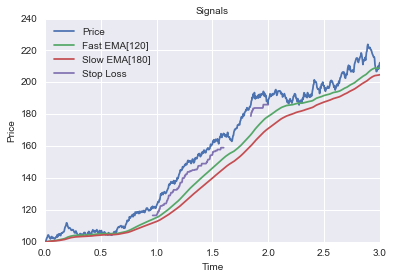

In [73]:
# extract the outputs
emaFast=strategyOutput['emaFast']
emaSlow=strategyOutput['emaSlow']
stopLevel=strategyOutput['stopLevel']
position=strategyOutput['position']
# plot the price and indicators
plotSignal(timeX,pricePaths,emaFast,emaSlow,stopLevel,position,fastLookback,slowLookback)

After the 30 stocks with the largest 90 day momentums are selected, the strategy enters the market if the fast EMA is above the slow EMA and places a stop 10 units of volatility below the market. As the market moves up, the trailing protective stop is moved up behind the market. The strategy exits on a retracement of 10 units of volatility or when the monmentum rank of the stop is greater than 30. The portfolio is rebalanced every 20 days.

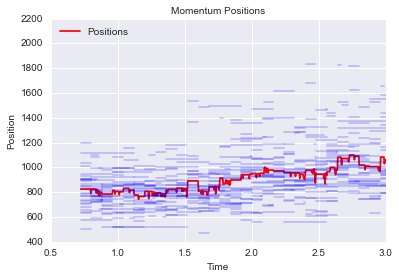

In [74]:
# splot the position sizes and average position size
plotPosition(timeX,position,nPositions)

The above graph depicts the position sizes for all traded instruments over time in addition to the average position size. The position size slowly increases over time because profit is re-invested in the strategy. As the strategy wins, position size is increased. As the strategy loses, the position size is decreased.

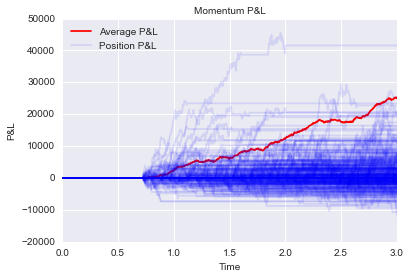

In [75]:
# extract the outputs
cumulativePnL=strategyOutput['cumulativePnL']
# plot the average P&L and the P&L for each instrument in the portfolio
plotPnL(timeX,cumulativePnL,nPositions)

The graph immediately above illustrates the profit and loss by instrument along with the average profit and loss across all instruments. We can see that losing trades are truncated by the trailing stop, while winning trades are held until they retrace.

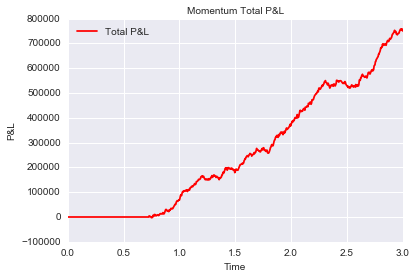

In [76]:
# plot the total P&L for the strategy
plotTotalPnL(timeX,cumulativePnL)

In this particular simulation, the price returns of the instruments are independent and the drift in each market is the same. This is the ideal situation where we have many price paths with long-term trending behavior driven by a common factor, but independent short-term behavior.

# Modeling
In the previous section, we provided an overview of our basic momentum strategy. In this section we first provide a brief overview of the theory underlying statistical factor analysis of the equity price returns in our chosen stock universe.

## Theory
In this section, we provide a brief overview the theoretical underpinnings of the modeling approach employed in our application. In particular, we provide an outline of the eigen-decomposition underlying the statistical factor analysis and outline an approach for determining how many investment components contribute to each statistical factor. We conclude this section by examining statistical factors derived from the prices returns of stocks in our investment universe, namely the S&P500.

### Standardized Returns

Standardization rescales a variable while preserving its order. 

We denote the daily return of the $i^{th}$ stock for the $m^{th}$ day as $r_{i,m}$ and define the standardized return as:

$$\hat{r}{i,m}=\frac{\left( r{i,m}-\bar{r}{i,M}\right)}{\sigma(r{i,M})}$$

Where

$\hat{r}_{i,m}$ is the standardized return of the $i^{th}$ stock for the $m^{th}$ day using data over the time interval one to $M$

$r_{i,m}$ is the observed return of the $i^{th}$ stock for the $m^{th}$ day

$\bar{r}{i,M}=\frac{1}{M}\sum{m=1}^{M}\left(\hat{r}_{m}\right)$ is the mean of the return stream of the $i^{th}$ investment over the time interval one to $M$

$\sigma(r_{i,M})=$ is the standard deviation of the returns for the $i^{th}$ stock over the time interval one to $M$

### Correlations

We represent the standardized returns as an $I$ x $M$ matrix $\hat{R}$ with an empirical correlation matrix $C$ defined as:

$$C = \frac{1}{M}\hat{R}\hat{R}^{T}$$

Where

$T$ denotes the matrix transform

The correlation matrix ($C$) of returns ($\hat{R}$) and the covariance matrix ($\Sigma_{\hat{R}}$) of standardized returns ($\hat{R}$) are identical.

## Principal Component Analysis (PCA)

The objective of principal component analysis (PCA) is to find a linear transformation $\Omega$ that maps a set of observed variables $\hat{R}$ into a set of uncorrelated variables $F$. We define the $I$ x $M$ statistical factor matrix as

$$F = \Omega\hat{R}$$

Where each row $f_{k}$ ($k = 1, \dots ,N$) corresponds to a factor $F$ of $\hat{R}$ and the transformation matrix $\Omega$ has elements $\omega_{k,i}$. The first row of $\omega_{1}$ (which contains the first set of factor coefficients or 'loadings') is chosen such that the first factor ($f_{1}$) is aligned with the direction of maximal variance in the $I$-dimensional space defined by $\hat{R}$. Each subsequent factor ($f_{k}$) accounts for as much of the remaining variance of the standardized returns $\hat{R}$ as possible, subject to the constraint that the $\omega_{k}$ are mutually orthogonal. The vectors $\omega_{k}$ are further constrained by requiring that $\omega_{k}\omega_{k}^{T}=1$ for all $k$.

The correlation matrix $C$ is an $I$ x $I$ diagonalizable symmetric matrix that can be written in the form

$$C = \frac{1}{M}EDE^{T}$$

Where $D$ is a diagonal matrix of eigenvalues $d$ and $E$ is an orthogonal matrix of the corresponding eigenvectors.

The eigenvectors of the correlation matrix $C$ correspond to the directions of maximal variance such that $\Omega=E^{T}$. Statistical factors / principal components $F$ are found using the diagonalization above. 

If the sign of every coefficient in a statistical factor $f_{k}$ is reversed, neither the variance of $f_{k}$ nor the orthogonality of $\omega$ with respect to each of the other eigenvectors changes. For this reason, the signs of factors (PCs) are arbitrary. This feature of PCA can be problematic when we are interested in the temporal evolution of factors.

### Proportion of Variance
The covariance matrix $\Sigma_{F}$ for the statistical factor matrix $F$ can be written as:

$$\Sigma_{F}=\frac{1}{M}FF^{T}=\frac{1}{M}\Omega\hat{R}\hat{R}^{T} \Omega^{T} = D$$

Where $D$ is the diagonal matrix of eigenvalues $d$.

The total variance of the standardized returns $\hat{R}$ for the $I$ stocks is then

$$\sum_{i=1}^{I}\sigma^{2}(\hat{r}{i})=tr(\Sigma{\hat{R}})=\sum_{i=1}^{I}d_{i}=\sum_{i=1}^{N}\sigma^{2}(f_{i})=tr(D)=I$$

Where $\Sigma_{\hat{R}}$ is the covariance matrix for $\hat{R}$ 

$\sigma^{2}(\hat{r_{i}})=1$ is the variance of the vector $\hat{r_{i}}$ of standardized returns for investment $i$.

The proportion of the total variance in $\hat{R}$ explained by the $k^{th}$ factor is then

$$\frac{\sigma^{2}(f_{k})}{\Sigma_{i=1}^{I}\sigma^{2}(\hat{r_{i}})}=\frac{d_{k}}{\Sigma_{i=1}^{I}d_{k}}=\frac{d_{k}}{I}$$

The proportion of the variance from the $k^{th}$ factor is equal to the ratio of the $k^{th}$ largest eigenvalue $d_{k}$ to the number of investments $I$.

### Number of Significant Components

To determine how many statistical factors are needed to describe the correlations between investments, many methods have been proposed. There is no widespread agreement on an optimal approach. In this paper we focus on the first factor where we are able to find a clear economic interpretation (i.e., the common equity market factor)

### Significant Statistical Factor Coefficients

An increase in the variance associated with a factor can be the result of increases in the correlations among only a few single stocks (which then have large factor coefficients) or an effect in which many single stocks make significant contributions to the factor. Since the two types of changes have very different implications for portfolio management, this distinction is critically important. It becomes much more difficult to reduce risk by diversifying across different single stocks when correlations between all single stocks increase. In contrast, increases in correlations within a sector when correlations between different sectors are not increasing have a less significant impact on diversification.

### Inverse Participation Ratio (IPR)
The inverse participation ratio $IPR_{k}$ of the $k^{th}$ factor $\omega_{k}$ is defined as:

$$IPR_{k}=\sum_{i=1}^{I}\left( \omega_{k,i}\right)^{4}$$

The IPR quantifies the reciprocal of the number of elements that make a significant contribution to each eigenvector.

The behavior of the IPR is bounded by two cases:

[1] An eigenvector with identical contributions $\omega_{k,i}=\frac{1}{\sqrt{I}}$ from all $I$ investments has $IPR_{k}=\frac{1}{I}$

[2] An eigenvector with a single factor $\omega_{k,i}=1$ and remaining factors equal to zero has $IPR=1$

The inverse of the IPR - the so-called participation ratio - provides a more intuitive measure of the significance of a given factor as a large $PR$ indicates that many investments contribute to the factor, while a small $PR$ signals that few investments contribute to the factor:

$$PR = \frac{1}{IPR_{k}}$$

The participation ratio quantifies the number of eigenvector (loading) components that participate in a factor and provides a measure of concentration.

The bigger a $PR$ is, the more participants the statistical factor has, the more uniformly distributed the participation is, and the more correlations are driven by the statistical factor.

Participation ratios facilitate the identification of statistical factors that represent macroeconomic scenarios, namely those with with many participants. They also help us identify factors that represent micro-economic scenarios, namely factors with few participants.

## Application: Exploring the Dependence Between Stocks Using PCA
In this section we explore the dependence between stocks in our investment universe using the measure described above.

The following functions implements the participation and inverse participation ratios:

In [55]:
# define the inverse participation ratio (IPR)
def inverseParticipationRatio(k,omega):
  # find the IPR
  IPR=numpy.sum(omega[:,k]**4)
  # return the IPR
  return IPR

# define the participation ratio (PR)
def PR(k,omega):
  # find the IPR
  IPR=inverseParticipationRatio(k,omega)
  # take the inverse of the IPR
  PR=1/IPR
  # return the PR
  return PR

We first compute the price returns for each stock in our cleaned universe.

In [56]:
# compute the price returns
priceReturns=cleanPrices.pct_change()

Next we standardize the returns:

In [57]:
T,nInstruments=priceReturns.shape
meanReturns = numpy.mean(priceReturns.values[1:-1,:],axis=0)
stdReturns = numpy.std(priceReturns.values[1:-1,:],ddof=1,axis=0)
normalizedReturns=(priceReturns.values[1:-1,:]-meanReturns)/stdReturns

We now compute the correlations between stocks and do the eigendecomposition:

In [58]:
C=numpy.cov(normalizedReturns,rowvar=0)
# compute the eigendecomposition
eigenvalues,eigenvectors=numpy.linalg.eig(C)
# sort the eigenvalues and eigenvalues
sortindex=numpy.argsort(-eigenvalues)
eigenvalues=eigenvalues[sortindex]
eigenvectors=eigenvectors[:,sortindex]

We determine the proportion of variance explained by each statistical factor as follows:

In [59]:
proportionOfVariance=eigenvalues/len(eigenvalues)
explainedVariance=numpy.cumsum(proportionOfVariance)
print(explainedVariance[0:20])

[ 0.43309119  0.46617202  0.49369426  0.51192059  0.52404187  0.53338539
  0.54191942  0.54905549  0.55584022  0.56154291  0.56716718  0.57186216
  0.57622623  0.58036022  0.58436659  0.58823744  0.59197443  0.59553778
  0.59893347  0.6022483 ]


We can see that the first factor explains 43% of the daily variation in our chosen equity universe.

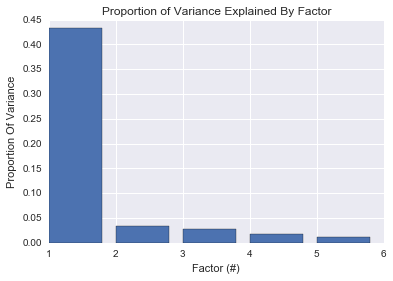

In [60]:
plt.bar(numpy.arange(1,6),proportionOfVariance[0:5])
plt.xlabel('Factor (#)')
plt.ylabel('Proportion Of Variance')
plt.title('Proportion of Variance Explained By First 5 Factors')

We can also see from the participation ratio that the almost all stocks in the universe contribute to the first factor.

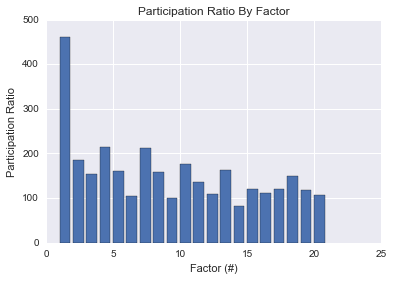

In [61]:
participationRatio=numpy.zeros([nInstruments,1])

for factorIndex in range(0,nInstruments):
    participationRatio[factorIndex]=PR(factorIndex,eigenvectors)

plt.bar(numpy.arange(1,20+1),participationRatio[0:20])
plt.ylabel('Participation Ratio')
plt.xlabel('Factor (#)')
plt.title('Participation Ratio By Factor')

Recall that the participation ratio represents the number of stocks that make a significant contribution to the statistical factor. With almost all stocks contributing significantly to the first factor it is clear that this factor represents the common co-movement across stocks.

### Sensitivity to Trend

In this section, we explore the response of our strategy to market conditions. In particular, we map the relationship between the magnitude of directinal movement (i.e., the trend) of the underlying markets and the P&L of the strategy. 

The following function is used to compute sensitivity of the momentum strategy to different drift scenarios.

In [77]:
def momentumCrossoverSensitivity(sensitivityInputs):
    # extract strategy inputs
    S0=sensitivityInputs['S0']
    sigma=sensitivityInputs['sigma']
    T=sensitivityInputs['T']
    nRows=sensitivityInputs['nRows']
    nPaths=sensitivityInputs['nPaths']
    minDrift=sensitivityInputs['minDrift']
    maxDrift=sensitivityInputs['maxDrift']
    nScenarios=sensitivityInputs['nScenarios']
    atrLookback=sensitivityInputs['atrLookback']
    atrMultiplier=sensitivityInputs['atrMultiplier']
    fastLookback=sensitivityInputs['fastLookback']
    slowLookback=sensitivityInputs['slowLookback']
    momentumLookback=sensitivityInputs['momentumLookback']
    longOnly=sensitivityInputs['longOnly']
    accountSize=sensitivityInputs['accountSize']
    fPercent=sensitivityInputs['fPercent']
    rebalanceN=sensitivityInputs['rebalanceN']
    nPositions=sensitivityInputs['nPositions']   
    
    # create the drift scenarios
    driftScenario=numpy.linspace(minDrift,maxDrift,nScenarios)

    # create the output arrays
    sensitivityPnL=numpy.zeros([int(nScenarios),int(nPaths)])
    for scenarioIndex in range(0,int(nScenarios)):
        # simulate scenarios price paths
        pricePaths=assetPaths(S0,driftScenario[scenarioIndex],sigma,T,nRows,nPaths)
        # create true range
        trueRangePaths=numpy.concatenate((numpy.zeros((1,int(nPaths))),abs(numpy.diff(pricePaths,axis=0))))        
        # build strategy input data structure
        strategyInputs=dict()
        strategyInputs['pricePaths']=pricePaths
        strategyInputs['trueRangePaths']=trueRangePaths
        strategyInputs['atrLookback']=atrLookback
        strategyInputs['atrMultiplier']=atrMultiplier
        strategyInputs['fastLookback']=fastLookback
        strategyInputs['slowLookback']=slowLookback
        strategyInputs['momentumLookback']=momentumLookback
        strategyInputs['longOnly']=longOnly
        strategyInputs['accountSize']=accountSize
        strategyInputs['fPercent']=fPercent
        strategyInputs['rebalanceN']=rebalanceN
        strategyInputs['nPositions']=nPositions
        # simulate strategy
        strategyOutput=momentumCrossoverWithStopClassic(strategyInputs)        
        # extract strategy output
        cumulativePnL=strategyOutput['cumulativePnL']

        sensitivityPnL[scenarioIndex,:]=cumulativePnL[-1,:]
    
    return sensitivityPnL,driftScenario

The following function is used to graph the relationship between the drift and the P&L of the momentum strategy.

In [78]:
def mapMomentumCrossover(sensitivityInputs):
    # set the long-only flag
    sensitivityInputs['longOnly']=True
    # compute the long-only sensitivity
    sensitivityPnL_L,driftScenario_L=momentumCrossoverSensitivity(sensitivityInputs)
    # set the long-only flag to long/short
    sensitivityInputs['longOnly']=False
    # compute the long/short sensitivity
    sensitivityPnL_LS,driftScenario_LS=momentumCrossoverSensitivity(sensitivityInputs)
    # extract the parameters
    sigma=sensitivityInputs['sigma']
    T=sensitivityInputs['T']
    S0=sensitivityInputs['S0']
    nPaths=sensitivityInputs['nPaths']    
    # create the figure
    fig = plt.figure()
    plt.plot(driftScenario_L,numpy.sum(sensitivityPnL_L,axis=1),label='Long-Only')
    plt.plot(driftScenario_LS,numpy.sum(sensitivityPnL_LS,axis=1),label='Long/Short')
    plt.xlabel("Drift ($\mu$)",fontsize=10)
    plt.ylabel("P&L",fontsize=10)
    plt.title('Sensitivity \n ($\sigma$='+str(sigma)+',T='+str(T)+',S0='+str(S0)+',nPaths='+str(nPaths)+')',fontsize=10)
    plt.grid(True)
    plt.legend(['Long-Only','Long/Short'],loc='lower right')    
            
    return

First we initialize the simulation parameters:

In [80]:
# strategy parameters
atrLookback=20.0
fastLookback=120.0
slowLookback=180.0
atrMultiplier=10.0
momentumLookback=90.0
rebalanceN=20.0
longOnly=True
accountSize=1000000.0
fPercent=0.005
nPositions=30.0

# price simulation parameters
S0=100.0
mu=0.1
sigma=0.1
T=3.0
nRows=750.0
nPaths=1000.0

# drfit sensitivity parameters
minDrift=-0.3
maxDrift=0.3
nScenarios=10

Then we map the relationship between the magnitude of the typical directional movement and the momentum strategy P&L.

C:\Users\DerekG\Anaconda2\lib\site-packages\ipykernel\__main__.py:77: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\DerekG\Anaconda2\lib\site-packages\ipykernel\__main__.py:82: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


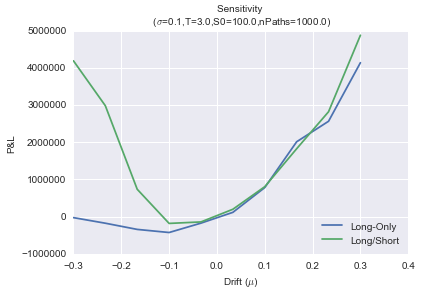

In [81]:
# create the input structure
sensitivityInputs=dict()
sensitivityInputs['S0']=S0
sensitivityInputs['sigma']=sigma
sensitivityInputs['T']=T
sensitivityInputs['nRows']=nRows
sensitivityInputs['nPaths']=nPaths
sensitivityInputs['minDrift']=minDrift
sensitivityInputs['maxDrift']=maxDrift
sensitivityInputs['nScenarios']=nScenarios
sensitivityInputs['atrLookback']=atrLookback
sensitivityInputs['atrMultiplier']=atrMultiplier
sensitivityInputs['fastLookback']=fastLookback
sensitivityInputs['slowLookback']=slowLookback
sensitivityInputs['momentumLookback']=momentumLookback
sensitivityInputs['accountSize']=accountSize
sensitivityInputs['fPercent']=fPercent
sensitivityInputs['rebalanceN']=rebalanceN
sensitivityInputs['nPositions']=nPositions
# create the sensitivities
mapMomentumCrossover(sensitivityInputs)

In the above sensitivity graph, the x-axis represents the drift ($\mu$) in prices (i.e., the trend), while the y-axis represents profit and loss (P&L) of the strategy. For the 'long-only' strategy we can see that the strategy performs well when the market is rising, but is flat or negative when the market is falling. For the 'long/short' strategy we can see that the strategy performs well when the market is either rising or falling sharply, but loses when the market does not move much.

Increasing transaction costs shift the profile down, increasing the magnitude of directional movement required for the strategy to be profitable.

In the next section we conduct a limited historical back-test.

## Momentum Strategy Backtest

In this section of the paper we use the cleaned prices to backtest our strategy. No parameter optimization is done. Instead, we select parameters that are commonly used. We focus on the general behavior of strategy.

In [82]:
#load the clean prices and true ranges

# set the back-test prices and true ranges
backtestPrices=cleanPrices.values[1:-1,:]
backtestTrueRanges=cleanTrueRanges.values[1:-1,:]

In [83]:
# strategy parameters
atrLookback=20.0
fastLookback=120.0
slowLookback=150.0
atrMultiplier=10.0
momentumLookback=90.0
rebalanceN=20.0
longOnly=True
accountSize=1000000.0
fPercent=0.005
nPositions=20

strategyInputs=dict()
strategyInputs['pricePaths']=backtestPrices
strategyInputs['trueRangePaths']=backtestTrueRanges
strategyInputs['atrLookback']=atrLookback
strategyInputs['atrMultiplier']=atrMultiplier
strategyInputs['fastLookback']=fastLookback
strategyInputs['slowLookback']=slowLookback
strategyInputs['momentumLookback']=momentumLookback
strategyInputs['longOnly']=longOnly
strategyInputs['accountSize']=accountSize
strategyInputs['fPercent']=fPercent
strategyInputs['rebalanceN']=rebalanceN
strategyInputs['nPositions']=nPositions
# simulate strategy
strategyOutput=momentumCrossoverWithStop(strategyInputs)

C:\Users\DerekG\Anaconda2\lib\site-packages\ipykernel\__main__.py:52: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


The P&L by instrument looks similar to our Monte 

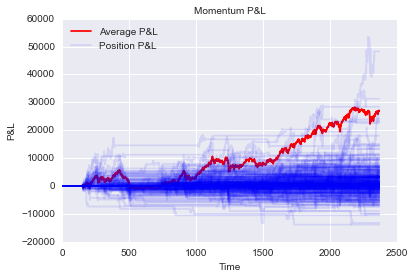

In [84]:
# extract the outputs
cumulativePnL=strategyOutput['cumulativePnL']
# plot the total P&L for the strategy
timeX=numpy.arange(0,cumulativePnL.shape[0])
plotPnL(timeX,cumulativePnL,nPositions)

In the above graph we see that the profile of the momentum strategy applied to our chosen equity universe appears similar to the profile that emerged in our Monte Carlo simulations. Losing trades are truncated by our trailing stop loss, while winning trades are allowed to run.

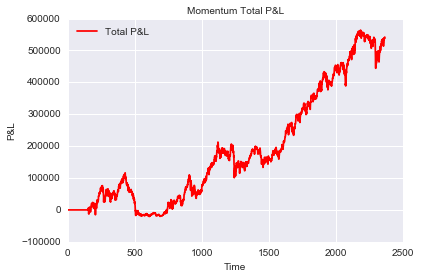

In [85]:
timeX=numpy.arange(0,cumulativePnL.shape[0])
plotTotalPnL(timeX,cumulativePnL)

Notice that the performance of our strategy is much rougher than the performance arrived at using Monte Carlo simulations. This difference in behavior reflects key features of real markets that can be exploited by adjusting our strategy to reduce positions as the importance of the first statistical factor increases over time. The high level of cross-dependence in the returns of our holdings likely contributes significantly to the volatility of our results.

## Conclusion

Unfortunately, the quality of publicly available data significantly limited our ability to construct a research-ready equity database for strategy back-testing. Full walk-forward testing with factor-based risk and performance attribution was abandoned in favor of sensitivity analysis as a way of limiting the impact of low quality data on the project. A basic momentum strategy was implemented and sensitivities were developed to illustrate the characteristics of the strategy. This basic infrastructure can be extended in the future to include all the components of a full back-testing engine for use with higher quality data. In particular, the strategy code can be optimized using either Cython or Numba.

## References

[1] C. Bacon [2008], Practical Portfolio Performance Measurement and Attribution, $2^{nd}$ Ed, John Wiley & Sons, Inc.

[2] A. F. Clenow [2015], Stocks on the Move: Beating the Market with Hedge Fund Momentum Strategies, CreateSpace Independent Publishing

[3] A. F. Clenow [2013], Following the Trend: Diversified Managed Futures Trading, John Wiley & Sons, Inc.

[4] D. J. Fenn, N. F. Johnson, N. S. Jones, M. McDonald, M. A. Porter, S. Williams [2011], Temporal evolution of financial-market correlations, Physical Review E 84, 026109

[5] F. J. Fabozzi, S. M. Focardi, P. N. Kolm [2010], Quantitative Equity Investing: Techniques and Strategies (Frank J. Fabozzi Series), John Wiley & Sons, Inc.

[6] N. Fenton, M. Neil [2013], Risk Assessment and Decision Analysis With Bayesian Networks, CRC Press

[7] A. Greyserman  and K. Kaminski [2013], Trend Following with Managed Futures: The Search for Crisis Alpha, John Wiley & Sons, Inc.

[8] A. Golub and Z. Guo [2012], Correlation Stress Tests Under the Random Matrix Theory: An Empirical Implementation to the Chinese Market

[9] R. H. Hua, E. E. Qian, and E. H. Sorensen [2007], Quantitative Equity Portfolio Management: Modern Techniques and Applications, Chapman and Hall/CRC Financial Mathematics Series

[10] D. Koller, N. Friedman [2009], Probabilistic graphical models: principles and techniques, MIT press.

[11] A Meucci [2009], Risk and Asset Allocation, $1^{st}$ Ed, Springer Berlin Heidelberg

[12] N. D. Pearson [2002], Risk Budgeting: Portfolio Problem Solving with Value-at-Risk, John Wiley & Sons, Inc. 

[13] R. Rebonato [2010], Plight of the Fortune Tellers: Why We Need to Manage Financial Risk Differently, Princeton University Press

[14] R. Rebonato [2010], Coherent Stress Testing: A Bayesian Approach to the Analysis of Financial Stress , John Wiley & Sons, Inc.

[15] R. Rebonato and A. Denev [2014], Portfolio Management Under Stress: A Bayesian-net Approach to Coherent Asset Allocation, Cambridge University Press

[15] D. Skillicorn [2007], Understanding Complex Datasets: Data Mining with Matrix Decompositions, Chapman and Hall/CRC

[16] R. Vince [2007], The Handbook of Portfolio Mathematics: Formulas for Optimal Allocation and Leverage, John Wiley & Sons, Inc.

[17] F. J. Fabozzi, S. M. Focardi, and P. N. Kolm [2010], Quantitative Equity Investing: Techniques and Strategies, John Wiley & Sons, Inc.

# Appendix: GitHub Repository
All of the Python code used to produce this paper can be found in the following github repository:

https://github.com/dgn2/IS_602.git

The github repository also contains this Jupyter notebook file, the HDF5 project data file, and includes code to:

* Extract the historical iShares S&P500 holdings files

* Create and load the historical iShares holdings to a MySQL database

* conduct limited exploratory analysis of the data

* conduct limited cleaning of the data used in subsequent statical modeling

* estimate statistical factors based on the price returns of a select portion of the S&P500 universe

* compute sensitivities
